<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

### Feature Ranking

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

By Michael J. Pyrcz <br />
&copy; Copyright 2024. 

This is a tutorial for / demonstration of **Feature Ranking**. 

**YouTube Lecture**: check out my lectures on:

* [Introduction to Machine Learning](https://youtu.be/zOUM_AnI1DQ?si=wzWdJ35qJ9n8O6Bl)
* [Curse of Dimensionality, Dimensionality Reduction, Principal Component Analysis](https://youtu.be/embks9p4pb8?si=B2HXm_i0oMSWkBhN)
* [Multidimensional Scaling and Random Projection](https://youtu.be/Yt0o8ukIOKU?si=_ri1NPwKVdhYzgO3)
* [Feature Transformations](https://youtu.be/6QJjZoWknEI?si=p6vp811xWAmzWY3r)

These lectures are all part of my [Machine Learning Course](https://youtube.com/playlist?list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&si=XonjO2wHdXffMpeI) on YouTube with linked well-documented Python workflows and interactive dashboards. My goal is to share accessible, actionable, and repeatable educational content. If you want to know about my motivation, check out [Michael's Story](https://michaelpyrcz.com/my-story). 

#### Motivation for Feature Ranking

There are often many predictor features (input variables), available for us to work with for building our prediction models. There are good reasons to be selective, throwing in every possible feature is not a good idea! In general, for the best prediction model, careful selection of the fewest features that provide the most amount of information is the best practice. 

Here's why:

* **blunders** - more predictor features result in more complicated workflows that require more professional time and have increased opportunity for mistakes in the workflow
* **difficult to visualize** - higher dimensional models, i.e., larger number of predictor features, are more difficult to visualize
* **model checking** - more complicated models may be more difficult to interrogate, interpret and QC
* **predictor feature redudancy** - more likely to have redudant predictor features. The inclusion of highly redundant and colinear or multicolinear features increases model variance, increase model instability and decreases prediction accuracy for testing
* **computational time** - more predictor features generally increase the computational time required to train the model and the computational storage, i.e., the model may be less compact and portable
* **model overfit** - the risk of overfit increases with the more features, due to increase in model complexity
* **model extrapolation** - many predictory features results in high dimensional model space with less data coverage and more likelihood for model extrapolation that may be inaccurate 

#### What is Feature Ranking?

Feature ranking is a set of metrics that assign relative importance or value to each predictor feature with respect to information contained for inference and importance in predicting a response feature. There are a wide variety of possible methods to accomplish this. My recommendation is a **'wide-array'** approach with multiple analyses and metrics, while understanding the assumptions and limitations of each method.  

Here's the general types of metrics that we consider for feature ranking.

1. Visual Inspection of Data Distributions and Scatter Plots
2. Statistical Summaries
3. Model-based
4. Recursive Feature Elimination

Also, we should not neglect expert knowledge. If additional information is known about physical processes, causation, reliability and availability of predictor features this should be integrated into assigning feature ranking.

#### Load the required libraries

The following code loads the required libraries.

In [3]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python  
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [5]:
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
from sklearn import preprocessing                             # remove encoding error
from sklearn.feature_selection import RFE                     # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression  # mutual information
from sklearn.linear_model import LinearRegression             # linear regression model
from sklearn.ensemble import RandomForestRegressor            # model-based feature importance
from sklearn import metrics                                   # measures to check our models
from statsmodels.stats.outliers_influence import variance_inflation_factor # variance inflation factor
import os                                                     # set working directory, run executables
import math                                                   # basic math operations
import random                                                 # for randon numbers
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import matplotlib.ticker as mtick                             # control tick label formatting
import seaborn as sns                                         # for matrix scatter plots
from scipy import stats                                       # summary statistics
import numpy.linalg as linalg                                 # for linear algebra
import scipy.spatial as sp                                    # for fast nearest neighbor search
import scipy.signal as signal                                 # kernel for moving window calculation
from numba import jit                                         # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map

For the Shapley value approach for feature ranking we need an additional package and to start up javascript support.

* after running this block you should see a hexgon with 'js' to indicate that javascript is ready

In [7]:
import sys
#!{sys.executable} -m pip install shap
import shap
shap.initjs()

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs. 

#### Design Custom Color Map

Accounting for significance by masking nonsignificant values

* for demonstration only currently, could be updated for each plot based on results confidence and uncertainty

In [9]:
my_colormap = plt.cm.get_cmap('RdBu_r', 256)                  # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))               # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])              # define white color (4 channel)
#newcolors[26:230, :] = white                                 # mask all correlations less than abs(0.8)
#newcolors[56:200, :] = white                                 # mask all correlations less than abs(0.6)
newcolors[76:180, :] = white                                  # mask all correlations less than abs(0.4)
signif = ListedColormap(newcolors)                            # assign as listed colormap
         
my_colormap = plt.cm.get_cmap('inferno', 256)                 # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))               # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])              # define white color (4 channel)
#newcolors[26:230, :] = white                                 # mask all correlations less than abs(0.8)
newcolors[0:12, :] = white                                    # mask all correlations less than abs(0.6)
#newcolors[86:170, :] = white                                 # mask all correlations less than abs(0.4)
sign1 = ListedColormap(newcolors)                             # assign as listed colormap

#### Declare functions

Here's a couple of functions to assist with calculating metrics for ranking and other plots:

* **plot_corr** - plot a correlation matrix

* **partial_corr** - partial correlation coefficient

* **semipar_corr** - semipartial correlation coefficient

* **mutual_matrix** - mutual information matrix, matrix of all pairwise mutual information

* **mutual_information_objective** - my modified version of the MRMR loss function (Ixy - average(Ixx)) for feature ranking (uses all other predictor features)

* **delta_mutual_information_quotient** - change in mutual information quotient by adding and rmeove a specific feature (uses all other predictor features for the comparison) 

* **weighted_avg_and_std** - average and standard deviation account for data weights

* **weighted_percentile** - percentile accounting for data weights

* **histogram_bounds** - add confidence intervals to histograms

* **add_grid** - convenience function to add major and minor gridlines to improve plot interpretability

Here are the functions:

In [11]:
def feature_rank_plot(pred,metric,mmin,mmax,nominal,title,ylabel,mask): # feature ranking plot
    mpred = len(pred); mask_low = nominal-mask*(nominal-mmin); mask_high = nominal+mask*(mmax-nominal)
    plt.plot(pred,metric,color='black',zorder=20)
    plt.scatter(pred,metric,marker='o',s=10,color='black',zorder=100)
    plt.plot([-0.5,m-1.5],[0.0,0.0],'r--',linewidth = 1.0,zorder=1)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric < nominal),interpolate=True,color='dodgerblue',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric > nominal),interpolate=True,color='lightcoral',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_low),metric,where=(metric < mask_low),interpolate=True,color='blue',alpha=0.8,zorder=10)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_high),metric,where=(metric > mask_high),interpolate=True,color='red',alpha=0.8,zorder=10)  
    plt.xlabel('Predictor Features'); plt.ylabel(ylabel); plt.title(title)
    plt.ylim(mmin,mmax); plt.xlim([-0.5,m-1.5]); add_grid();
    return

def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.cm.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0,vmin = -1.0*limits, vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns); ax = plt.gca()
    ax.xaxis.set_label_position('bottom'); ax.xaxis.tick_bottom()
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.colorbar(im, orientation = 'vertical')
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])

def partial_corr(C):                                          # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C):                                      # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] 
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                               # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                        # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):                   # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def weighted_avg_and_std(values, weights):                    # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():                                               # add major and minor gridlines
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [13]:
#os.chdir("d:/PGE383")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE").  

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

Let's load the provided multivariate, spatial dataset 'unconv_MV.csv'. This dataset has variables from 1,000 unconventional wells including:

* well average porosity
* log transform of permeability (to linearize the relationships with other variables)
* accoustic impedance (kg/m^3 x m/s x 10^6)
* brittness ratio (%)
* total organic carbon (%)
* vitrinite reflectance (%)
* initial production 90 day average (MCFPD).  

Note, the dataset is synthetic.

We load it with the pandas 'read_csv' function into a DataFrame we called 'my_data' and then preview it to make sure it loaded correctly.

In [15]:
#df = pd.read_csv('unconv_MV_v4.csv')                         # load our data table
df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv') # load data from Dr. Pyrcz's GitHub respository  

response = 'Prod'                                             # specify the response feature
x = df.copy(deep = True); x = x.drop(['Well',response],axis='columns') # make predictor and response DataFrames
Y = df.loc[:,response]

features = x.columns.values.tolist() + [Y.name]               # store the names of the features
pred = x.columns.values.tolist()
resp = Y.name

xmin = [6.0,0.0,1.0,10.0,0.0,0.9]; xmax = [24.0,10.0,5.0,85.0,2.2,2.9] # set the minumum and maximum values for plotting
Ymin = 500.0; Ymax = 9000.0

predlabel = ['Porosity (%)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Brittleness Ratio (%)', # set the names for plotting
             'Total Organic Carbon (%)','Vitrinite Reflectance (%)']
resplabel = 'Normalized Initial Production (MCFPD)'

predtitle = ['Porosity','Permeability','Acoustic Impedance','Brittleness Ratio', # set the units for plotting
             'Total Organic Carbon','Vitrinite Reflectance']
resptitle = 'Normalized Initial Production'

featurelabel = predlabel + [resplabel]                        # make feature labels and titles for concise code
featuretitle = predtitle + [resptitle]

m = len(pred) + 1
mpred = len(pred)

* We can also establish the feature ranges for plotting. We could calculate the feature range directly from the data with code like this:

```p
Pormin = np.min(df['Por'].values)                             # extract ndarray of data table column
Pormax = np.max(df['Por'].values)                             # and calculate min and max
```

but, this would not result in easy to understand color bars and axis scales, let's pick convenient round numbers. We will also declare feature labels for ease of plotting. 

#### Visualize the DataFrame

Visualizing the DataFrame is useful first check of the data.

* many things can go wrong, e.g., we loaded the wrong data, all the features did not load, etc.

We can preview by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). 

* add parameter 'n=13' to see the first 13 rows of the dataset.  

In [17]:
df.head(n=13)                                                 # we could also use this command for a table preview 

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,1695.360819
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3007.096063
2,3,14.02,2.59,4.01,72.80,0.89,2.72,2531.938259
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5288.514854
4,5,17.52,4.57,3.18,10.94,1.51,1.90,2859.469624
5,6,14.53,4.81,2.69,53.60,0.94,1.67,4017.374438
6,7,13.49,3.60,2.93,63.71,0.80,1.85,2952.812773
7,8,11.58,3.03,3.25,53.00,0.69,1.93,2670.933846
8,9,12.52,2.72,2.43,65.77,0.95,1.98,2474.048178
9,10,13.25,3.94,3.71,66.20,1.14,2.65,2722.893266


#### Summary Statistics for Tabular Data

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. 

* We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [19]:
df.describe().transpose()                                     # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Well,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303506,4752.637555,8590.384044


Ranking features is really an effort to understand the features and their relationships with eachother.  We will start with basic data visualization and move to more complicated methods such are partial correlation and recursive feature elimination.

### Ranking Method - Coverage

Let's start with the concept of feature coverage. 

* If a feature is available over a small proportion of the samples then we may not want to include it as it will result in issues with feature imputation, estimation of missing data.

* By removing a couple features with poor coverage we may improve our model because there are limitations with feature imputation, feature imputation can actually impose bias in statistics and additional error in our prediction models

* if likewise deletion is applied to deal with missing values, features with low coverage result in a lot of removed data!

Let's start with a bar chart with the proportion of missing records:

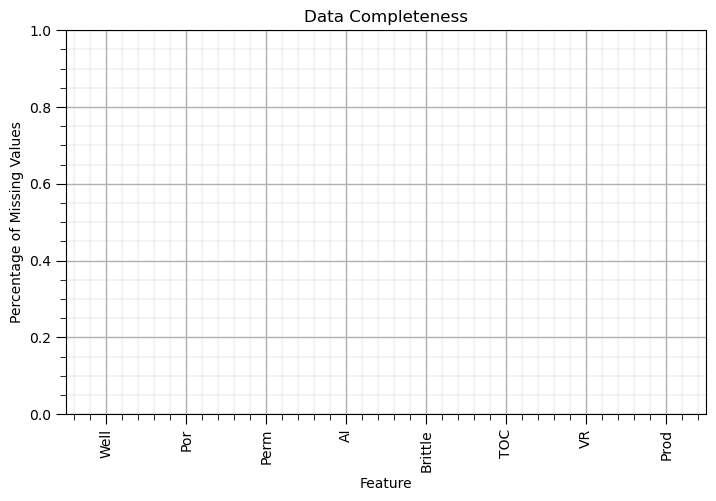

In [21]:
plt.subplot(111)
(df.isnull().sum()/len(df)).plot(kind = 'bar')                # calculate DataFrame with percentage missing by feature
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.2); add_grid(); plt.show()

For the provided example dataset the plot should be empty. There are no missing data so the 'Proportion of Missing Records' is 0.0 for all features. 

If you wanted to test this plot with some missing data, run this code first:

```python
proportion_NaN = 0.1                                    # proportion of values in DataFrame to remove

remove = np.random.random(df.shape) < proportion_NaN    # make the boolean array for removal
print('Fraction of removed values in mask ndarray = ' + str(round(remove.sum()/remove.size,3)) + '.')

df_mask = df.mask(remove)                               # make a new DataFrame with specified proportion removed
```

Remove this code and reload the data to continue to get consistent results with the discussions below.

This does not tell the whole story. For example, if 20% of feature A is missing and 20% of feature B is missing are those the same and different samples. This has a huge impact if you perform likewise deletion.

* If there is not too much data then we can actually visualize data coverage over all samples and features in a boolean table like this.
* This method may indentify specific samples with many missing features that may be removed to improve overall coverage or other trends or structures in the missing data that may result in sampling bias.

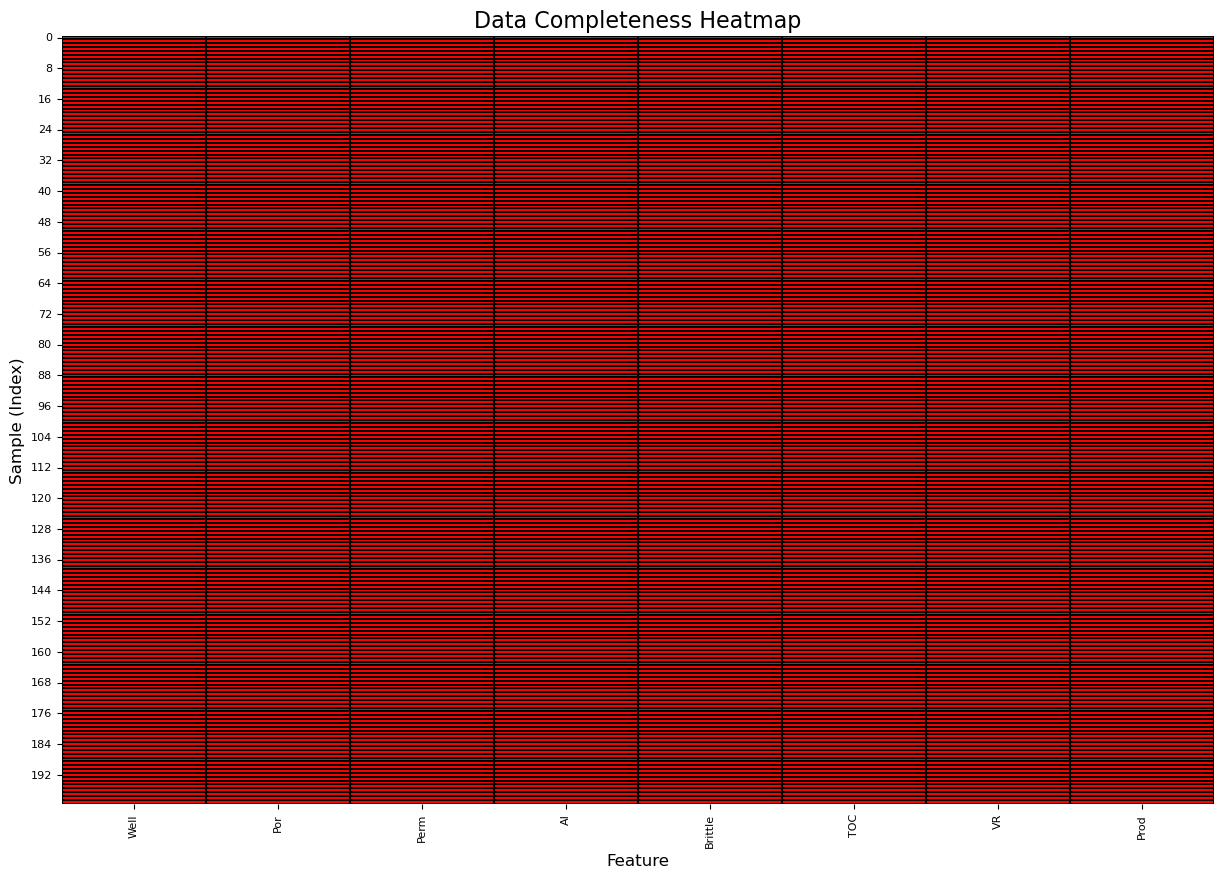

In [23]:
df_temp = df.copy(deep=True)                                  # make a deep copy of the DataFrame
df_bool = df_temp.isnull()                                    # true is value, false if NaN
#df_bool = df_bool.set_index(df_temp.pop('UWI'))              # set the index / feature for the heat map y column
heat = sns.heatmap(df_bool, cmap=['r','w'], annot=False, fmt='.0f',cbar=False,linecolor='black',linewidth=0.1) # make the binary heat map, no bins
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=8)
heat.set_yticklabels(heat.get_yticklabels(), rotation=0, fontsize=8)
heat.set_title('Data Completeness Heatmap',fontsize=16); heat.set_xlabel('Feature',fontsize=12); heat.set_ylabel('Sample (Index)',fontsize=12)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.6, wspace=0.2, hspace=0.2); plt.show()

Once again this plot should be quite boring for the provided dataset with perfect coverage, every cell should be filled in red. 

* add the code to remove some records to test this plot. White cells are missing records.

#### Feature Imputation

See the chapter on feature imputation to learn what to do about missing data.

For now a concise treatment here, we will just apply likewise delection and move on.

* we remove all samples with any missing feature values. While this is quite simple, it is a sledge hammer approach to ensure perfect coverage required by feature ranking methods that we are about to demonstrate. Please check out the other methods in the linked workflow above.

In [25]:
df.dropna(axis=0,how='any',inplace=True)                      # likewise deletion

### Ranking Method - Summary Statistics

In any multivariate work we should start with the univariate analysis, summary statistics of one variable at a time. The summary statistic ranking method is qualitative, we are asking:

* are there data issues?
* do we trust the features? do we we trust the features all equally?
* are there issues that need to be taken care of before we develop any multivariate workflows?

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a compact data table. We use transpose() command to flip the table so that features are on the rows and the statistics are on the columns.

In [27]:
df.describe().transpose()                                     # DataFrame summary statistics

,count,mean,std,min,25%,50%,75%,max
Well,200.0,100.500000,57.879185,1.000000,50.750000,100.500000,150.250000,200.000000
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,3864.407081,1553.277558,839.822063,2686.227611,3604.303506,4752.637555,8590.384044


Summary statistics are a critical first step in data checking. 

* this includes the number of valid (non-null) values for each feature (count removes all np.NaN from the totals for each variable).

* we can see the general behavoirs such as central tendency, mean, and dispersion, variance. 

* we can identify issue with negative values, extreme values, and values that are outside the range of plausible values for each property. 

We have some negative TOC values! Let's check the distribution.

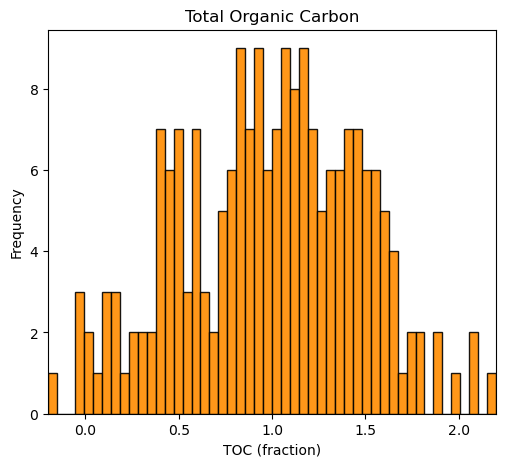

In [29]:
plt.subplot(111)                                              # histogram
GSLIB.hist_st(df['TOC'].values,-.2,2.2,log=False,cumul = False,bins=50,weights = None,xlabel='TOC (fraction)',title='Total Organic Carbon')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=0.8, wspace=0.1, hspace=0.2)
plt.show()

* There are just a couple slighly negative values, let's just truncate them at zero. We   can use this command below to set all TOC values in the DataFrame that are less than 0.0 as 0.0, otherwise we keep the original TOC value.

In [31]:
df['TOC'] = np.where(df['TOC']<0.0, 0.0, df['TOC'])           # set TOC < 0.0 as 0.0, otherwise leave the same
df['TOC'].describe().transpose()                              # summary statistics just for TOC

count    200.000000
mean       0.991950
std        0.478264
min        0.000000
25%        0.617500
50%        1.030000
75%        1.350000
max        2.180000
Name: TOC, dtype: float64

The data looks to be in pretty good shape and for brevity we skip outlier detection. Let's look at the univariate distributions.

### Ranking Method - Univariate Distributions

As with summary statistics, this ranking method is a qualitative check for issues with the data and to assess our confidence with each feature. It is better to not include a feature with low confidence of quality as it may be misleading (while adding to model complexity as discussed previously).  

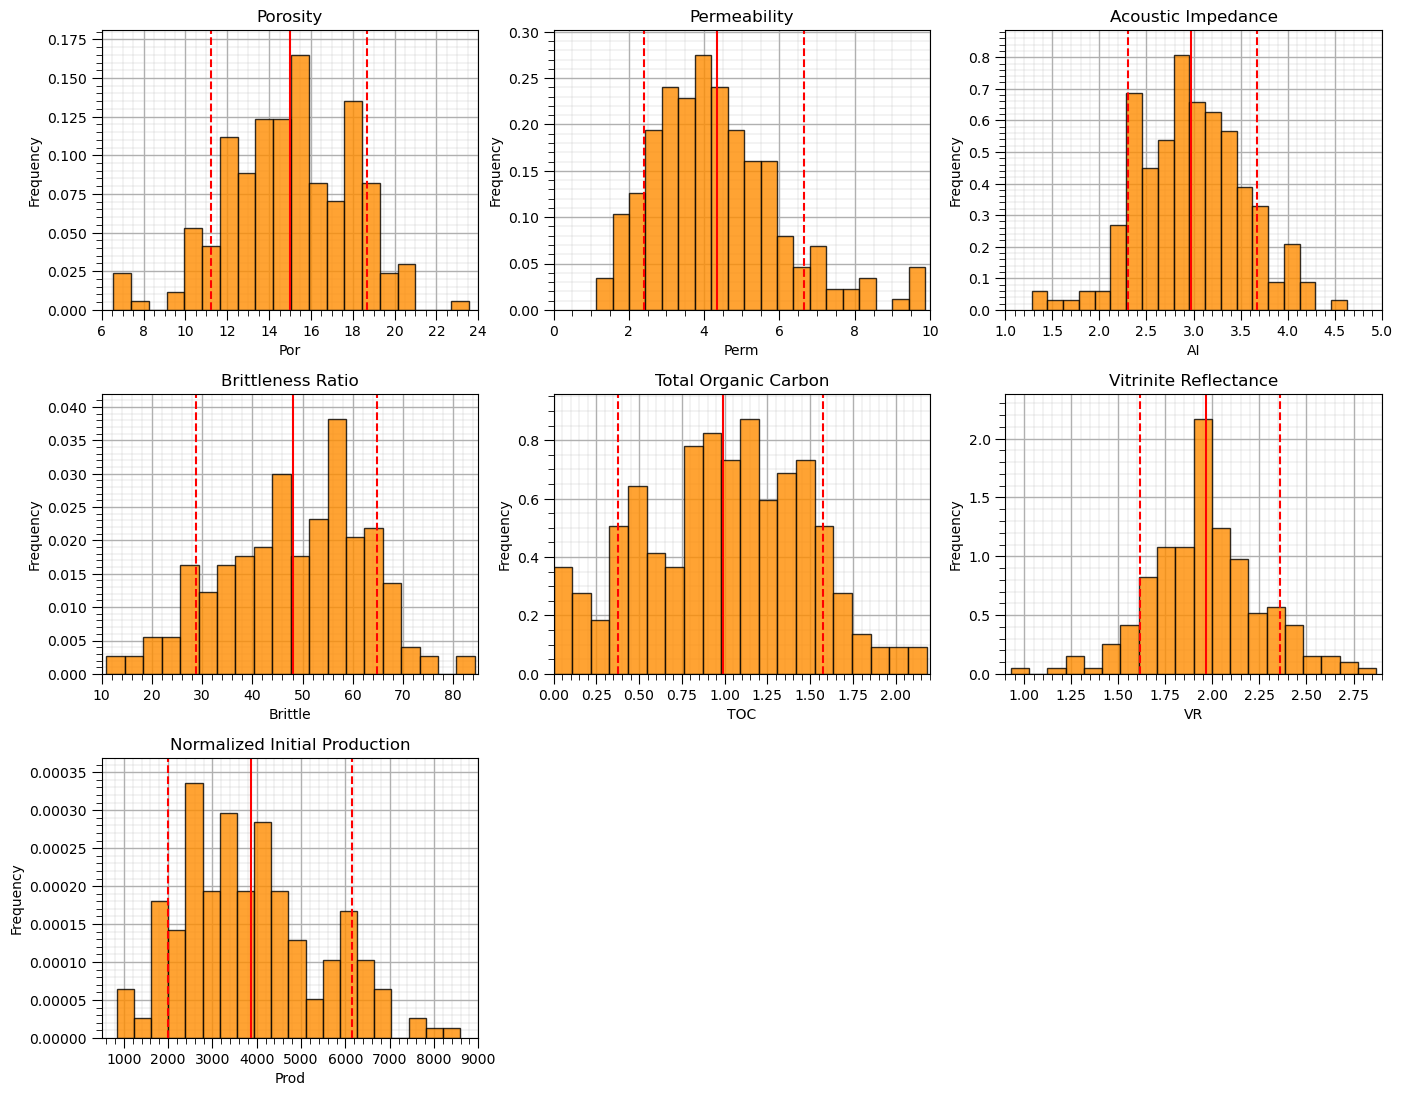

In [33]:
nbins = 20                                                    # number of histogram bins
for i, feature in enumerate(features):                        # plot histograms with central tendancy and P10 and P90 labelled
    plt.subplot(3,3,i+1)
    y,_,_ = plt.hist(x=df[feature],weights=None,bins=nbins,alpha = 0.8,edgecolor='black',color='darkorange',density=True)
    histogram_bounds(values=df[feature].values,weights=np.ones(len(df)),color='red')
    plt.xlabel(feature); plt.ylabel('Frequency'); plt.ylim([0.0,y.max()*1.10]); plt.title(featuretitle[i]); add_grid() 
    if feature == resp:   
        plt.xlim([Ymin,Ymax])    
    else:
        plt.xlim([xmin[i],xmax[i]]) 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=2.1, wspace=0.2, hspace=0.3); plt.show()

The univariate distributions look good:

* there are no obvious outliers
* the permeability is postively skewed as often observed
* the corrected TOC has a small spike, but it's reasonable

### Ranking Method - Bivariate Distributions

Matrix scatter plots are a very efficient method to observe the bivarate relationships between the variables.  

* this is another opportunity through data visualization to identify data issues
* we can assess if we have collinearity, specifically simpler form between two features at a time. 

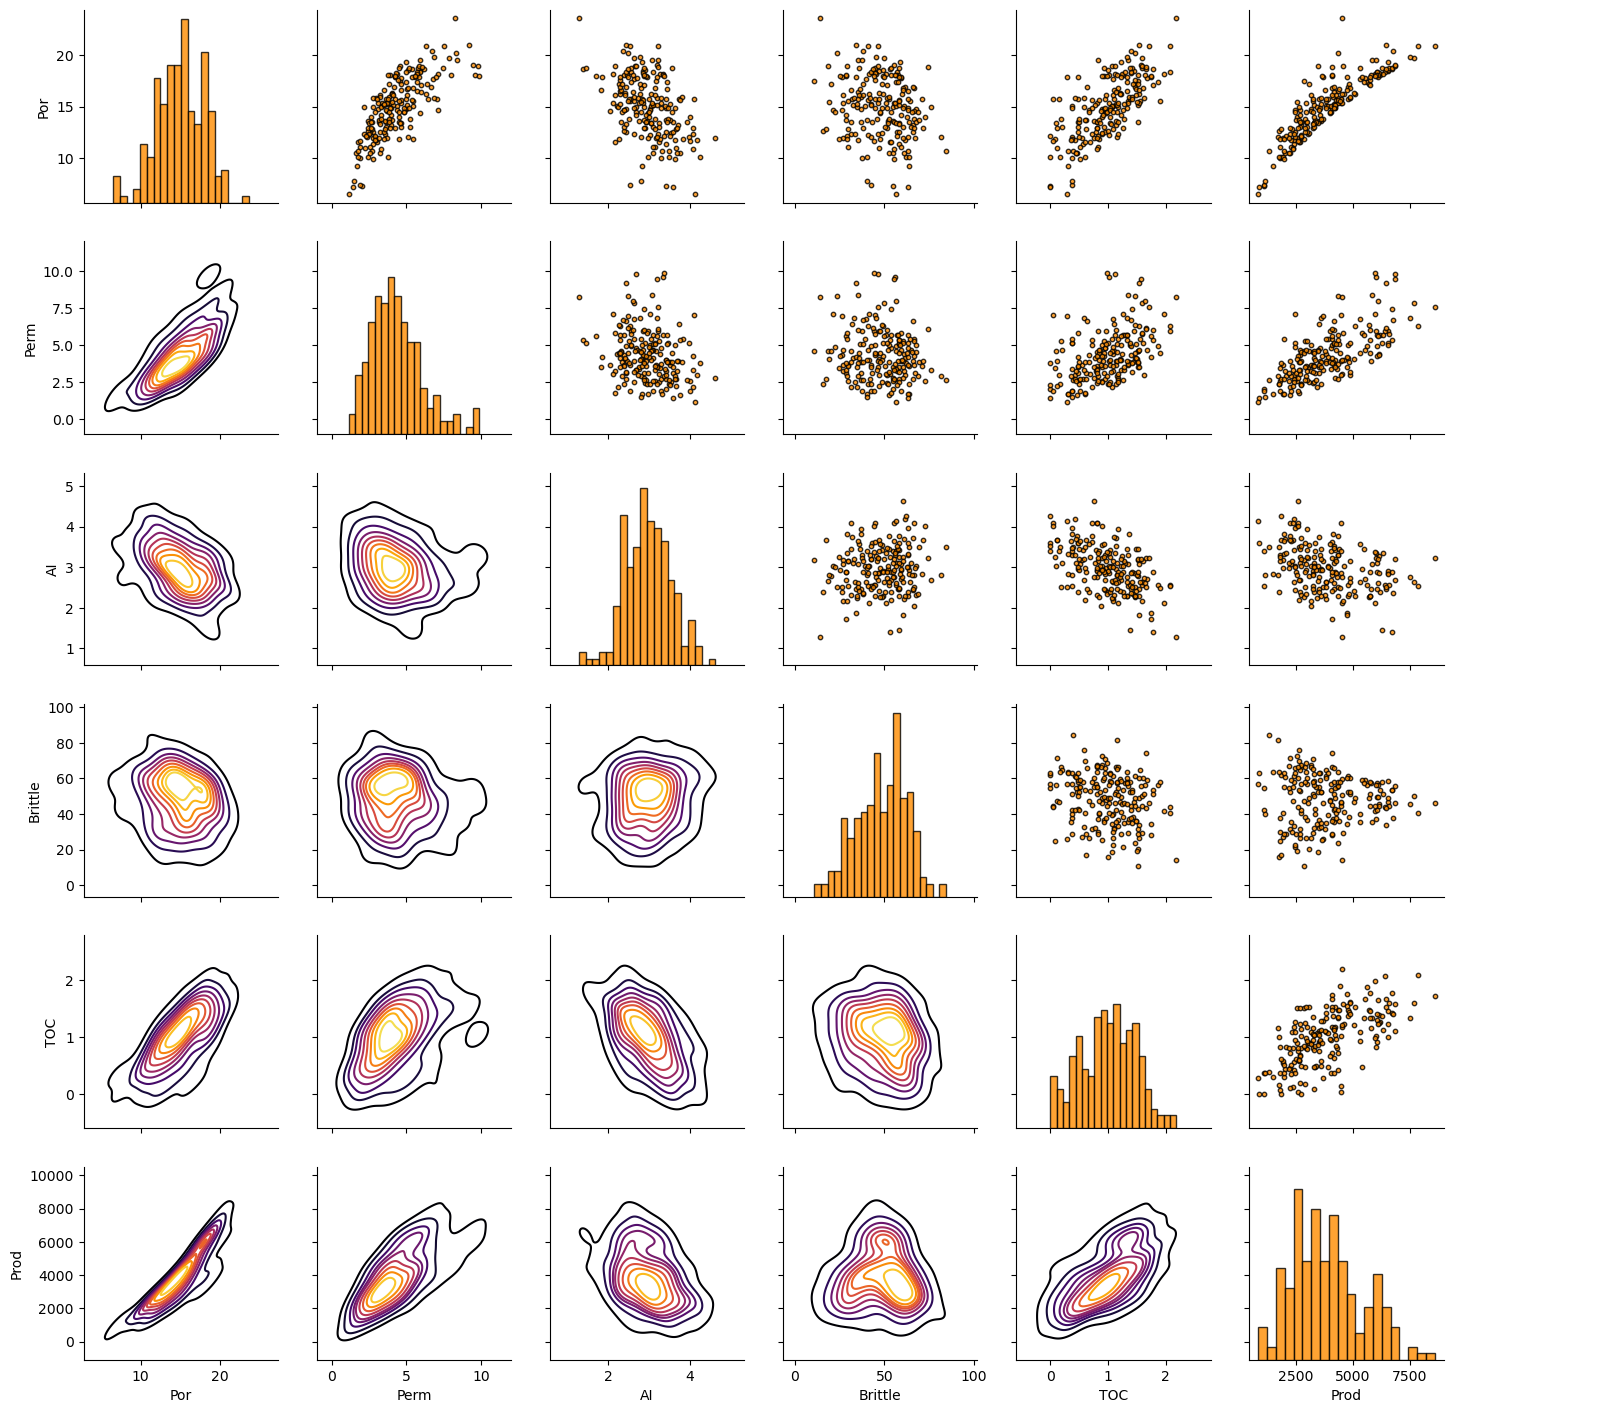

In [35]:
pairgrid = sns.PairGrid(df,vars=['Por','Perm','AI','Brittle','TOC','Prod']) # matrix scatter plots
pairgrid = pairgrid.map_upper(plt.scatter, color = 'darkorange', edgecolor = 'black', alpha = 0.8, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'darkorange',alpha = 0.8, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, shade_lowest = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2); plt.show()

This plot communicates a lot of information. How could we use this plot for variable ranking?

* we can identify features that are closely related to eachother, e.g., if two features have almost a perfect monotonic linear or near linear relationship we should remove one immediately. This is a simple case of colinearity that will likley result in model instability as discussed above.

* we can check for linear vs. non-linear relationships. If we observe nonlinear bivariate relationships this will impact the choice of methods, and the quality of results from methods that assume linear relationships for variable ranking.

* we can identify constraint relationships and heteroscedasticity between variables. Once again these may restrict our ranking methods and also encourage us to retains specific features to retain these features in the resulting model. 

Yet, we must remember that bivariate visualization and analysis is not sufficient to understand all the multivariate relationships in the data, e.g., multicollinearity includes strong linear relationships between 2 or more features. These may be hard to see with only bivariate plots.

### Ranking Method - Pairwise Covariance

Pairwise covariance provides a measure of the strength of the linear relationship between each predictor feature and the response feature. At this point, we specify that the goal of this study is to predict production, our response variable, from the other available predictor features. We are thinking predictively now, not inferentially, we want to estimate the function, $\hat{f}$, to accomplish this:

$$
Y = \hat{f}(X_1,\ldots,X_n) 
$$

where $Y$ is our response feature and $X_1,\ldots,X_n$ are our predictor features. If we retained all of our predictor features to predict the response we would have: 

$$
Prod = \hat{f}(Por,Perm,AI,Brittle,TOC,VR) 
$$

Now back to the covariance, the covariance is defined as:  

$$
C_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)}
$$

Covariance:
* measures the linear relationship
* sensitive to the dispersion / variance of both the predictor and response

We can use the follow command to build a covariance matrix:

```p
df.iloc[:,1:8].cov()                                    # covariance matrix sliced predictors vs. response
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with the covariances between all predictors features and the response.


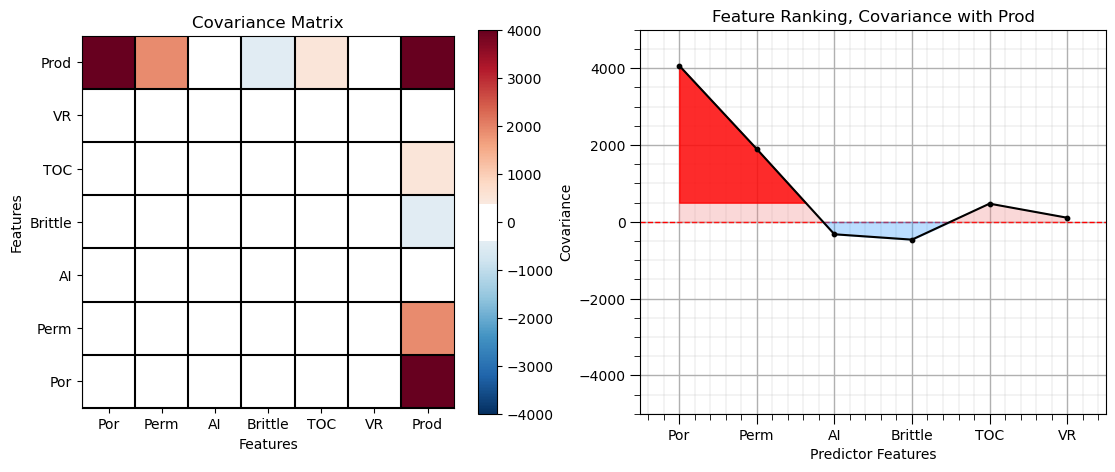

In [37]:
covariance = df.iloc[:,1:8].cov().iloc[6,:6]                  # calculate covariance matrix and slice for only pred - resp

cov_matrix = df.iloc[:,1:8].cov()
plt.subplot(121)
plot_corr(cov_matrix,'Covariance Matrix',4000.0,0.1)          # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features') 

plt.subplot(122)
feature_rank_plot(pred,covariance,-5000.0,5000.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance',0.1)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=0.8, wspace=0.2, hspace=0.3); plt.show()

The covariance is useful, but as you can see the magnitude is quite variable. 

* the covaraince magnitudes are a function of each feature's feature and feature variance is somewhat arbitrary.
* for example, what is the variance of porosity in fraction vs. percentage or permeaiblity in Darcy vs. milliDarcy. We can show that if we apply a constant multiplier, $c$, to a feature, $X$, that the variance will change according to this relationship (the proof is based on expectation formulation of variance):

$$
\sigma_{cX}^2 = c^2 \cdot \sigma_{X}^2
$$

By moving from percentage to fraction we decrease the variance of porosity by a factor of 10,000! The variance of each feature is potentially arbitrary, with the exception when all the features are in the same units. 

Pairwise correlations are standardized covariances; therefore, avoids this arbitrary magnitude issue. 

### Ranking Method - Pairwise Correlation Coefficient

Pairwise correlation coefficient provides a measure of the strength of the linear relationship between each predictor feature and the response feature.  

$$
\rho_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)\sigma_x \sigma_y}, \, -1.0 \le \rho_{xy} \le 1.0
$$

The correlation coefficient:

* measures the linear relationship
* removes the sensitiviety to the dispersion / variance of both the predictor and response features, by normalizing by the product of the standard deviation of each feature 

We can use the follow command to build a correlation matrix:

```p
df.iloc[:,1:8].corr()
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with the correlations between all predictors features and the response.


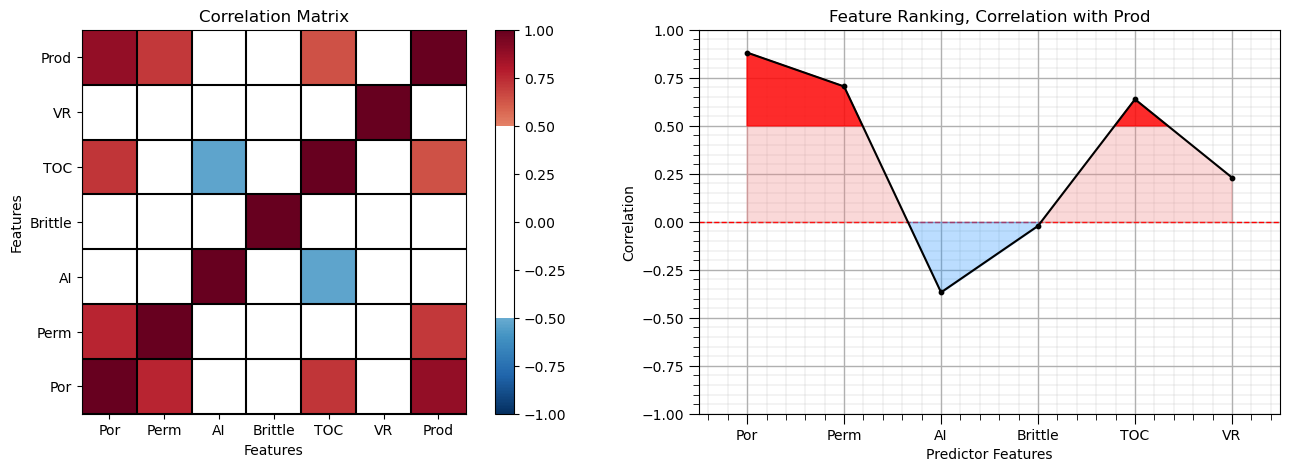

In [39]:
correlation = df.iloc[:,1:8].corr().iloc[6,:6]                # calculate correlation matrix and slice for only pred - resp
corr_matrix = df.iloc[:,1:8].corr()

plt.subplot(121)
plot_corr(corr_matrix,'Correlation Matrix',1.0,0.5)           # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

plt.subplot(122)
feature_rank_plot(pred,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

From the correlation matrix we can observe:

* We see that porosity, permeability and total organic carbon have the strongest linear relationships with production. 
* Acoustic impedance has weak negative relationships with production.
* Brittleness is very close to 0.0. If you review the brittleness vs. production scatterplot, you'll observe a complicated non-linear relationship. There is a brittleness ratio sweetspot for production (rock that is not too soft nor too hard)!

We could also look at the full correlation matrix to evaluate the potential for redudancy between predictor features.

* strong degree of correlation between porosity and permeability and porosity and TOC
* strong degree of negative correlation between TOC and acoustic impedance

We are still limited to a strick linear relationship.  The rank correlation allows us to relax this assumption.

### Ranking Method - Pairwise Spearman Rank Correlation Coefficient

The rank correlation coefficient applies the rank transform to the data prior to calculating the correlation coefficent. To calculate the rank transform simply replace the data values with the rank $R_x = 1,\dots,n$, where $n$ is the maximum value and $1$ is the minimum value. 

$$
\rho_{R_x R_y}  = \frac{\sum_{i=1}^{n} (R_{x_i} - \overline{R_x})(R_{y_i} - \overline{R_y})}{(n-1)\sigma_{R_x} \sigma_{R_y}}, \, -1.0 \le \rho_{xy} \le 1.0
$$

$$
x_\alpha, \, \forall \alpha = 1,\dots, n, \, | \, x_i \ge x_j \, \forall \, i \gt j 
$$

$$
R_{x_i} = i
$$

The rank correlation:

* measures the monotonic relationship, relaxes the linear assumption
* removes the sensitiviety to the dispersion / variance of both the predictor and response, by normalizing by the product of the standard deviation of each. 

We can use the follow command to build a rank correlation matrix and calculate the p-value:

```p
stats.spearmanr(df.iloc[:,1:8])
```
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with 
the correlations between all predictors features and the response.

Also, we get a very convenient *pval* 2D ndarry with the two-sided (two-tail summing semmetric over both tails) p-value for a hypothesis test with: 

$$
H_o: \rho_{R_x R_y} = 0
$$

$$
H_1: \rho_{R_x R_y} \ne 0
$$

Let's keep the p-values between all the predictor features and our response feature.


Rank Correlation p-value:

[1.04774522e-75 6.96211663e-31 2.93927576e-08 4.14609952e-01
 1.53807742e-25 3.29170847e-04]


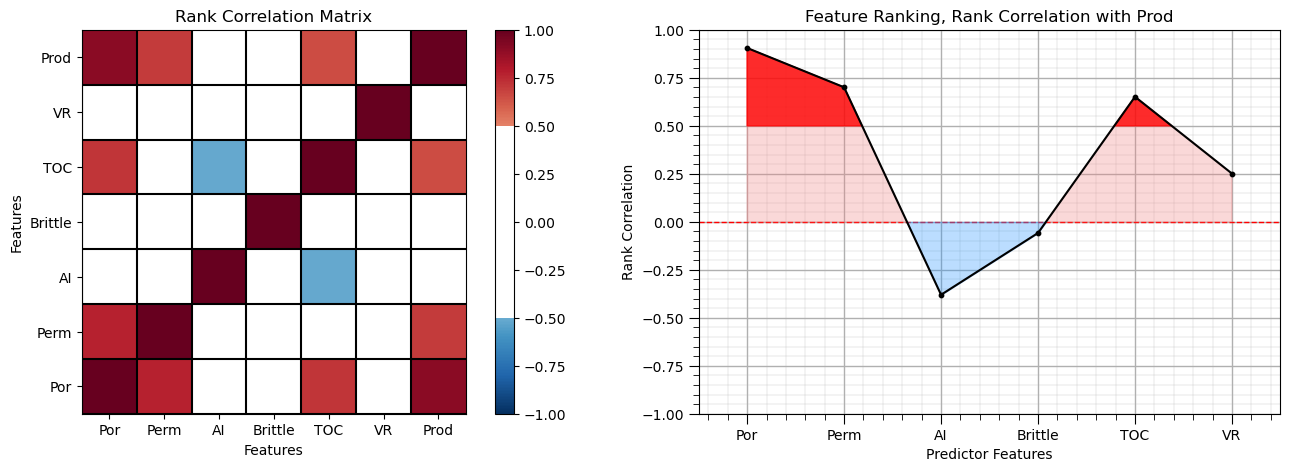

In [41]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,1:8]) # calculate the range correlation coefficient
rank_matrix = pd.DataFrame(rank_correlation,columns=corr_matrix.columns)
rank_correlation = rank_correlation[:,6][:6]
rank_correlation_pval = rank_correlation_pval[:,6][:6]
print("\nRank Correlation p-value:\n"); print(rank_correlation_pval)

plt.subplot(121)
plot_corr(rank_matrix,'Rank Correlation Matrix',1.0,0.5)      # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

plt.subplot(122)
feature_rank_plot(pred,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

There matrix and line plots indicate that the rank correlation coefficients are similar to the correlation coefficients indicating that nonlinearity and outliers are not likely impacting the correlation-based feature ranking. 

With regard to rank correlation p-values, 

* at a typical alpha value of 0.05, only the rank correlation between brittleness and production does not fail the hypothesis test; therefore, is not significantly different than 0.0. 

It is useful to look at the difference between the correlation coefficient and rank correlation coefficient.

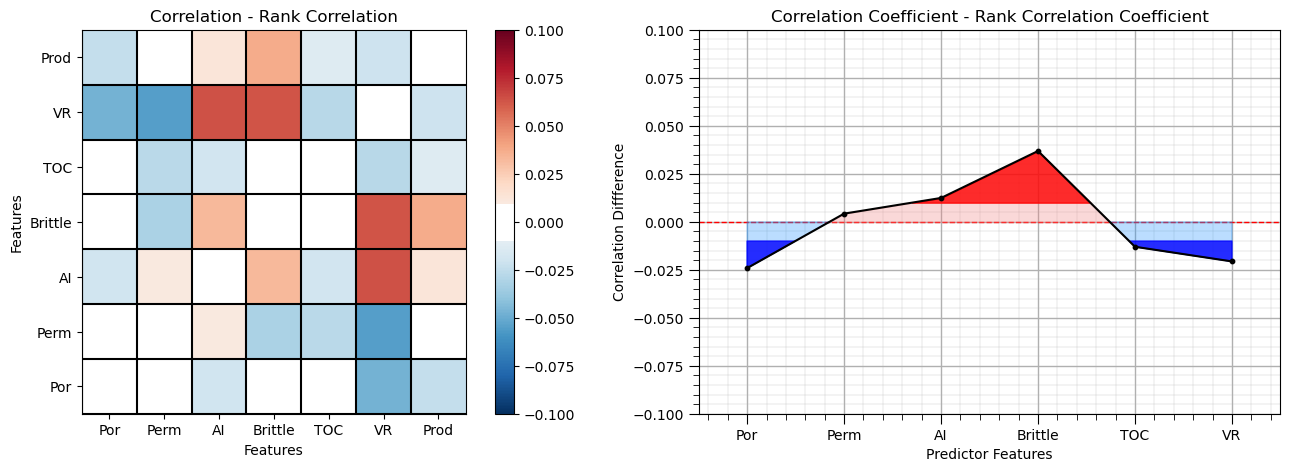

In [43]:
plt.subplot(121)                                              # plot correlation matrix with significance colormap
diff = corr_matrix.values - rank_matrix.values
diff_matrix = pd.DataFrame(diff,columns=corr_matrix.columns)
plot_corr(diff_matrix,'Correlation - Rank Correlation',0.1,0.1) # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

corr_diff = correlation - rank_correlation

plt.subplot(122)
feature_rank_plot(pred,corr_diff,-0.10,0.10,0.0,'Correlation Coefficient - Rank Correlation Coefficient','Correlation Diffference',0.1)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

Here are some interesting observations:

* correlation of porosity and vitrinite reflectance with production improve when we reduce the impact of linearity and outliers
* correlation of brittleness with production worsen wehen we reduce the impact of linearity and outliers

All of these methods up to now have considered one feature at a time. We can also consider methods that consider all features jointly to 'isolate' the influence of each feature.

### Ranking Method - Partial Correlation Coefficient

This is a linear correlation coefficient that controls for the effects all the remaining variables, $\rho_{XY.Z}$ and $\rho_{YX.Z}$ is the partial correlation between $X$ and $Y$, $Y$ and $X$, after controlling for $Z$.

To calculate the partial correlation coefficient between $X$ and $Y$ given $Z_i, \forall \quad i = 1,\ldots, m-1$ remaining features we use the following steps:

1. perform linear, least-squares regression to predict $X$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $X$ is regressed on the predictors to calculate the estimate, $X^*$

2. calculate the residuals in Step \#1, $X-X^*$, where $X^* = f(Z_{1,\ldots,m-1})$, linear regression model

3. perform linear, least-squares regression to predict $Y$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $Y$ is regressed on the predictors to calculate the estimate, $Y^*$

4. calculate the residuals in Step #3, $Y-Y^*$, where $Y^* = f(Z_{1,\ldots,m-1})$, linear regression model

5. calculate the correlation coefficient between the residuals from Steps #2 and #4, $\rho_{X-X^*,Y-Y^*}$

The partial correlation, provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other features on both, $X$ and $Y$.  We use the function declared previously taken from Fabian Pedregosa-Izquierdo, f@bianp.net. The original code is on GitHub at https://git.io/fhyHB.

To use this method we must assume:

1. two variables to compare, $X$ and $Y$
2. other variables to control, $Z_{1,\ldots,m-2}$ 
3. linear relationships between all variables
4. no significant outliers
5. approximately bivariate normality between the variables

We are in pretty good shape, but we have some departures from bivariate normality. We could consider Gaussian univariate transforms to improve this. This option is provided later.

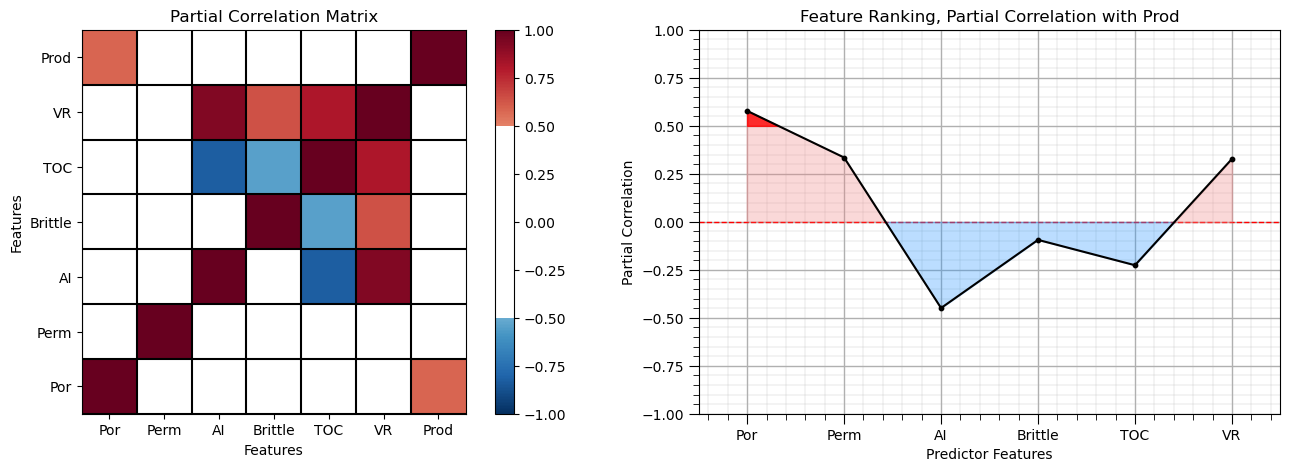

In [45]:
partial_correlation = partial_corr(df.iloc[:,1:8])            # calculate the partial correlation coefficients
partial_matrix = pd.DataFrame(partial_correlation,columns=corr_matrix.columns)
partial_correlation = partial_correlation[:,6][:6]            # extract a single row and remove production with itself

plt.subplot(121)
plot_corr(partial_matrix,'Partial Correlation Matrix',1.0,0.5) # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

plt.subplot(122)
feature_rank_plot(pred,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

Now we see a lot of new things about the unique contributions of each predictor feature! 

* porosity and permeability are strongly correlated with each other so they are penalized severely 

* acoustic impedance's and vitrinite reflectance's absolute correlation are increased reflecting their unique contributions

* total organic carbon flipped signs!  When we control for all other variables, it has a negative relationship with production. 

With the partial correlation coefficients we have controlled for the influence of all other predictor features on both the specific predictor and the response features. The semipartial correlation filters out the influence of all other predictor features on the raw response variable. 

### Ranking Method - Semipartial Correlation Coefficient

This is a linear correlation coefficient that controls for the effects all the remaining features, $Z$ on $X$, and then calculates the correlation between the residual $X^*-X$ and $Y$.  Note: we do not control for influence of $Z$ features on the response feature, $Y$. 

To calculate the semipartial correlation coefficient between $X$ and $Y$ given $Z_i, \forall \quad i = 1,\ldots, m-1$ remaining features we use the following steps:

1. perform linear, least-squares regression to predict $X$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $X$ is regressed on the remaining predictor features to calculate the estimate, $X^*$

2. calculate the residuals in Step \#1, $X-X^*$, where $X^* = f(Z_{1,\ldots,m-1})$, linear regression model

3. calculate the correlation coefficient between the residuals from Steps #2 and $Y$ response feature, $\rho_{X-X^*,Y}$

The semipartial correlation coefficient, provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other predictor features on the predictor feature, $X$, to get the unique contribution of $X$ with respect to $Y$. We use a modified version of the partial correlation function that we declared previously. The original code is on GitHub at https://git.io/fhyHB.

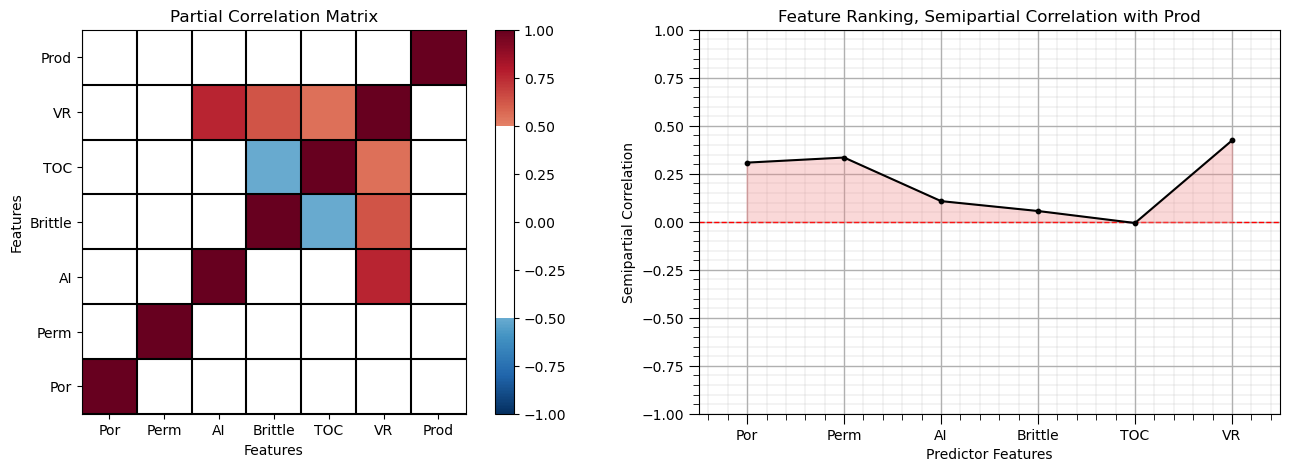

In [47]:
semipartial_correlation = semipartial_corr(df.iloc[:,1:8])    # calculate the semi-partial correlation coefficients
semipartial_matrix = pd.DataFrame(semipartial_correlation,columns=corr_matrix.columns)
semipartial_correlation = semipartial_correlation[:,6][:6]    # extract a single row and remove production with itself

plt.subplot(121)
plot_corr(semipartial_matrix,'Partial Correlation Matrix',1.0,0.5) # using our correlation matrix visualization function
plt.xlabel('Features'); plt.ylabel('Features')

plt.subplot(122)
feature_rank_plot(pred,semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.3); plt.show()

More information to consider:

* porosity, permeability and vitrinite reflectance are the most important by this feature ranking method
* all other predictor features have quite low correlations

This is a good moment to stop and take stock of all the results from the quantitative methods.  We will plot them all together.

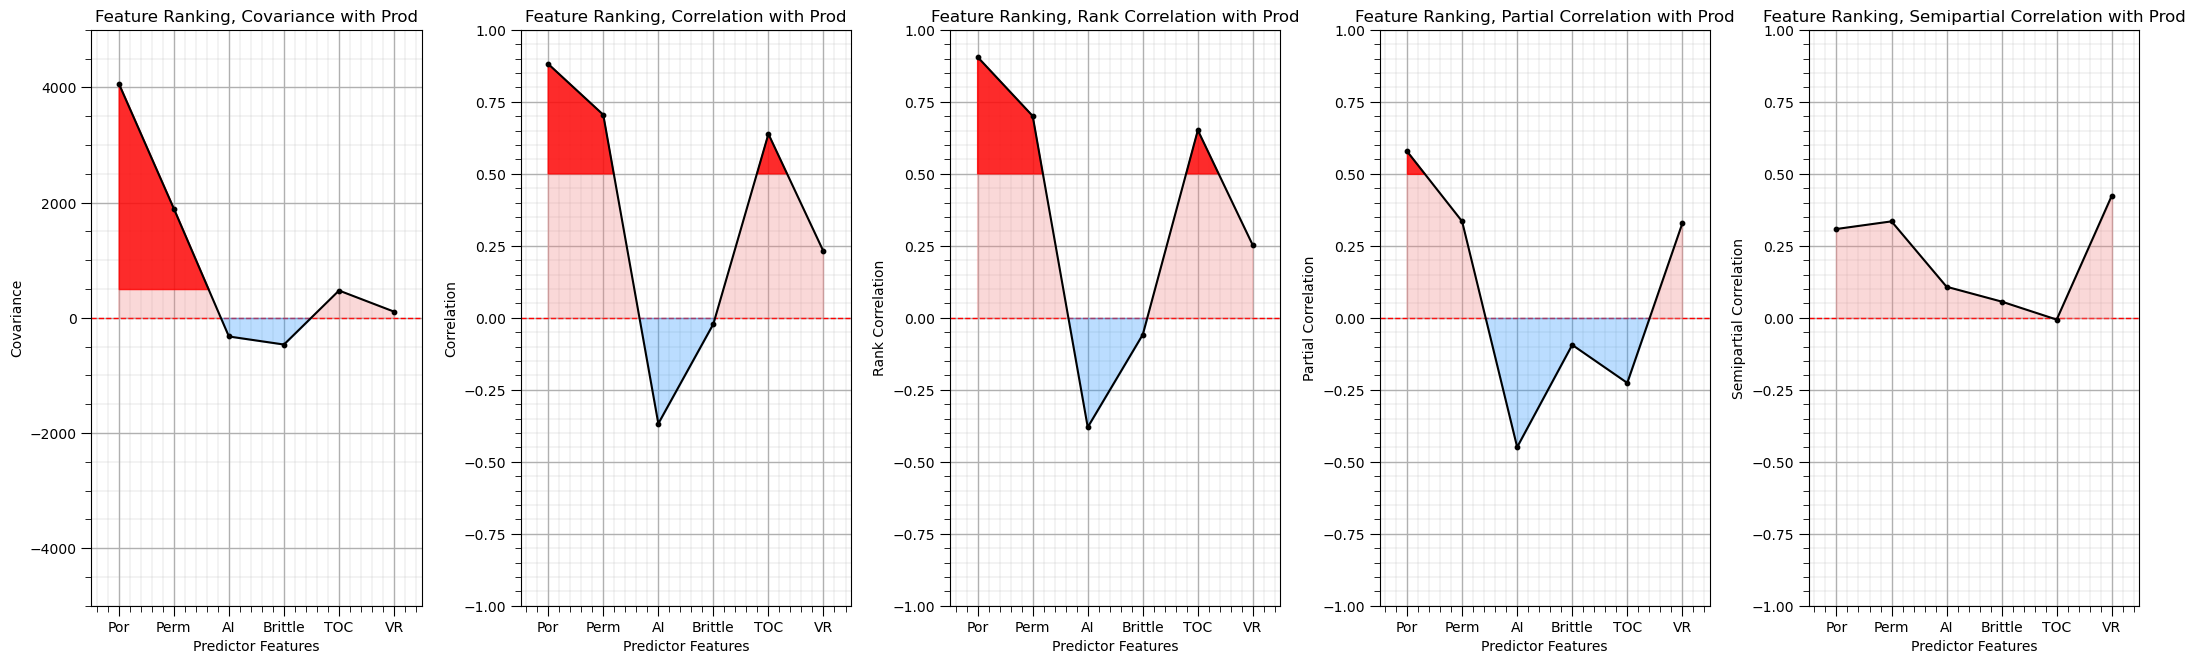

In [49]:
plt.subplot(151)
feature_rank_plot(pred,covariance,-5000.0,5000.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance',0.1)

plt.subplot(152)
feature_rank_plot(pred,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation',0.5)

plt.subplot(153)
feature_rank_plot(pred,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplot(154)
feature_rank_plot(pred,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

plt.subplot(155)
feature_rank_plot(pred,semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2); plt.show()

I think we are converging on porosity, permeability and vitrinite reflectance as the most important variables with respect to linear relationships with the production.  

### Repeat with Standardization or Normal Score Transform of All Features

There are many reasons to perform feature transformations (see the associated chapter) and as mentioned above for partial and semipartial correlation a distribution transformation may assist with compliance to metric assumptions. 

* As an exercise and check, let's standardize all the features and repeat the previously calculated quantitative methods. We know this will have an impact on covariance, what about the other metrics?

There is a bunch of code to get this done, but it isn't too complicated. First, lets make a new DataFrame with all variables standardized. Then we can make a minor edit (change the DataFrame name) and reuse the code from above. You can choose between:

1. Afine Correction - scale the distributions to have $\overline{x} = 0$ and $\sigma_x = 1.0$.
2. Normal Score Transform - distribution transform of each feature to standard normal, Gaussian shape with $\overline{x} = 0$ and $\sigma_x = 1.0$.

Use this block to perform affine correction of the features:

In [51]:
# dfS = pd.DataFrame()                                        # affine correction, standardization to a mean of 0 and variance of 1 
# dfS['Well'] = df['Well'].values
# dfS['Por'] = GSLIB.affine(df['Por'].values,0.0,1.0)
# dfS['Perm'] = GSLIB.affine(df['Perm'].values,0.0,1.0)
# dfS['AI'] = GSLIB.affine(df['AI'].values,0.0,1.0)
# dfS['Brittle'] = GSLIB.affine(df['Brittle'].values,0.0,1.0)
# dfS['TOC'] = GSLIB.affine(df['TOC'].values,0.0,1.0)
# dfS['VR'] = GSLIB.affine(df['VR'].values,0.0,1.0)
# dfS['Prod'] = GSLIB.affine(df['Prod'].values,0.0,1.0)
# dfS.head()

Use this block to perform normal score transform of the features:

In [53]:
dfS = pd.DataFrame()                                          # Gaussian transform, standardization to a mean of 0 and variance of 1 

dfS['Well'] = df['Well'].values
dfS['Por'],d1,d2 = geostats.nscore(df,'Por')
dfS['Perm'],d1,d2 = geostats.nscore(df,'Perm')
dfS['AI'],d1,d2 = geostats.nscore(df,'AI')
dfS['Brittle'],d1,d2 = geostats.nscore(df,'Brittle')
dfS['TOC'],d1,d2 = geostats.nscore(df,'TOC')
dfS['VR'],d1,d2 = geostats.nscore(df,'VR')
dfS['Prod'],d1,d2 = geostats.nscore(df,'Prod')
dfS.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,-0.964092,-0.780664,-0.285841,2.432379,0.312053,1.114651,-1.780464
1,2,-0.832725,-0.378580,0.446827,-0.195502,-0.272809,-0.325239,-0.392079
2,3,-0.312053,-1.069155,1.722384,2.004654,-0.272809,2.241403,-0.832725
3,4,0.730638,1.325516,-0.531604,-0.590284,0.131980,-0.325239,0.815126
4,5,0.698283,0.298921,0.365149,-2.870033,1.047216,-0.259823,-0.531604


Regardless of transform that you chose it it good to check the summary statistics.  

In [55]:
dfS.describe()                                                # check the summary statistics

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000,2.000000e+02
mean,100.500000,-0.009700,0.010306,9.732356e-03,8.028717e-05,0.016625,0.017360,1.617223e-03
std,57.879185,1.040456,1.005488,1.000221e+00,1.000278e+00,0.983649,1.000401,9.949811e-01
min,1.000000,-4.991462,-3.355431,-2.782502e+00,-2.870033e+00,-2.108358,-2.899210,-2.483589e+00
25%,50.750000,-0.670577,-0.647337,-6.588985e-01,-6.705770e-01,-0.670577,-0.651072,-6.705770e-01
50%,100.500000,0.006267,0.006267,8.881784e-16,8.881784e-16,0.018807,0.006267,8.881784e-16
75%,150.250000,0.670577,0.678574,6.705770e-01,6.705770e-01,0.682378,0.682642,6.705770e-01
max,200.000000,2.807034,2.807034,2.807034e+00,2.807034e+00,2.807034,2.807034,2.807034e+00


We should also check the matrix scatter plot again.

* If you performed normal score transform, you have standardized the mean and variance and correct the univariate shape of the distribution, but the bivariate relationships still depart from Gaussian.

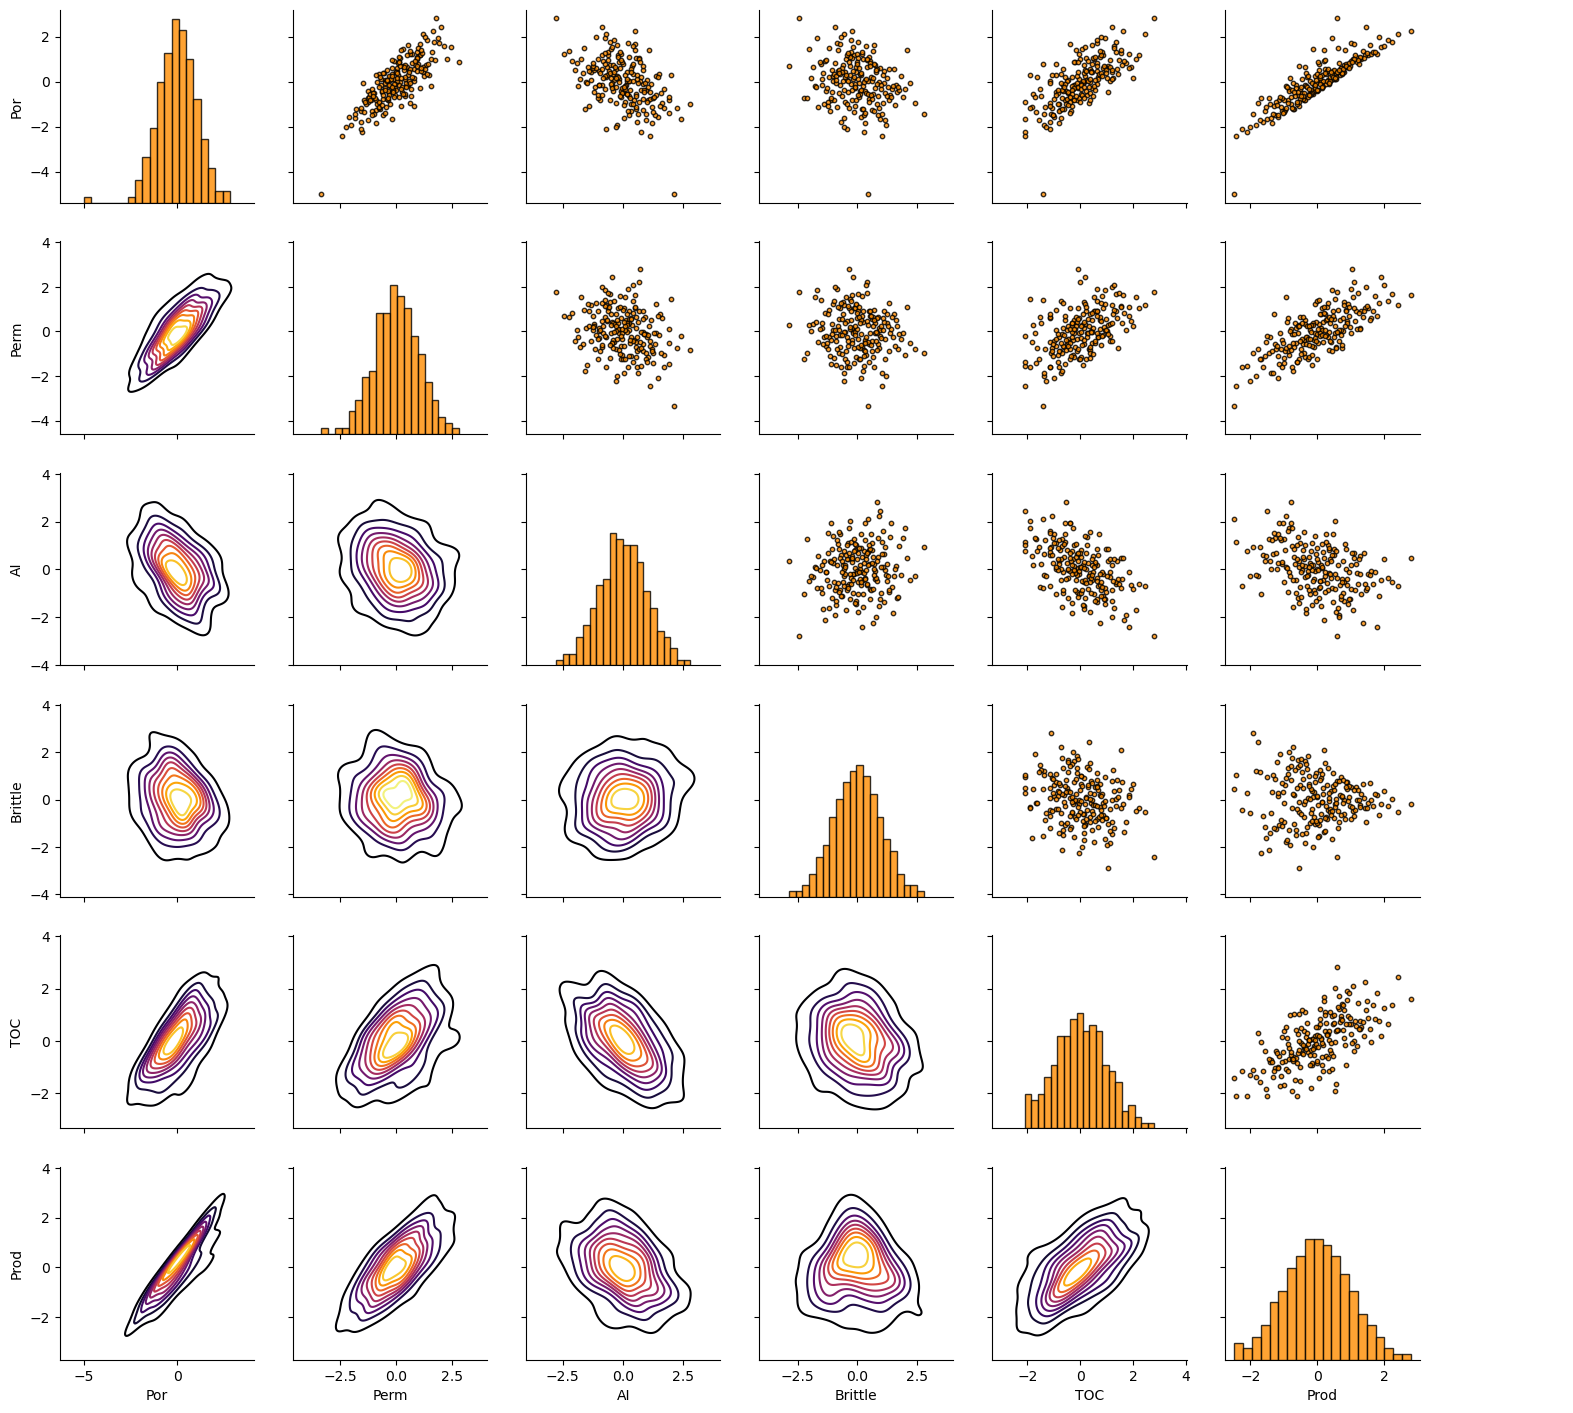

In [57]:
pairgrid = sns.PairGrid(dfS,vars=['Por','Perm','AI','Brittle','TOC','Prod']) # matrix scatter plots
pairgrid = pairgrid.map_upper(plt.scatter, color = 'darkorange', edgecolor = 'black', alpha = 0.8, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'darkorange',alpha = 0.8, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, shade_lowest = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2); plt.show()

This is the new DataFrame with standardized variables. Now we repeat the previous calculations. 

* We will be more efficient this time and use quite compact code.

In [59]:
stand_covariance = dfS.iloc[:,1:8].cov().iloc[6,:6]
stand_correlation = dfS.iloc[:,1:8].corr().iloc[6,:6]
stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(dfS.iloc[:,1:8])
stand_rank_correlation = stand_rank_correlation[:,6][:6]
stand_rank_correlation_pval = stand_rank_correlation_pval[:,6][:6]
stand_partial_correlation = partial_corr(dfS.iloc[:,1:8])
stand_partial_correlation = stand_partial_correlation[:,6][:6]
stand_semipartial_correlation = semipartial_corr(dfS.iloc[:,1:8])
stand_semipartial_correlation = stand_semipartial_correlation[:,6][:6]

and repeat the previous summary plot.

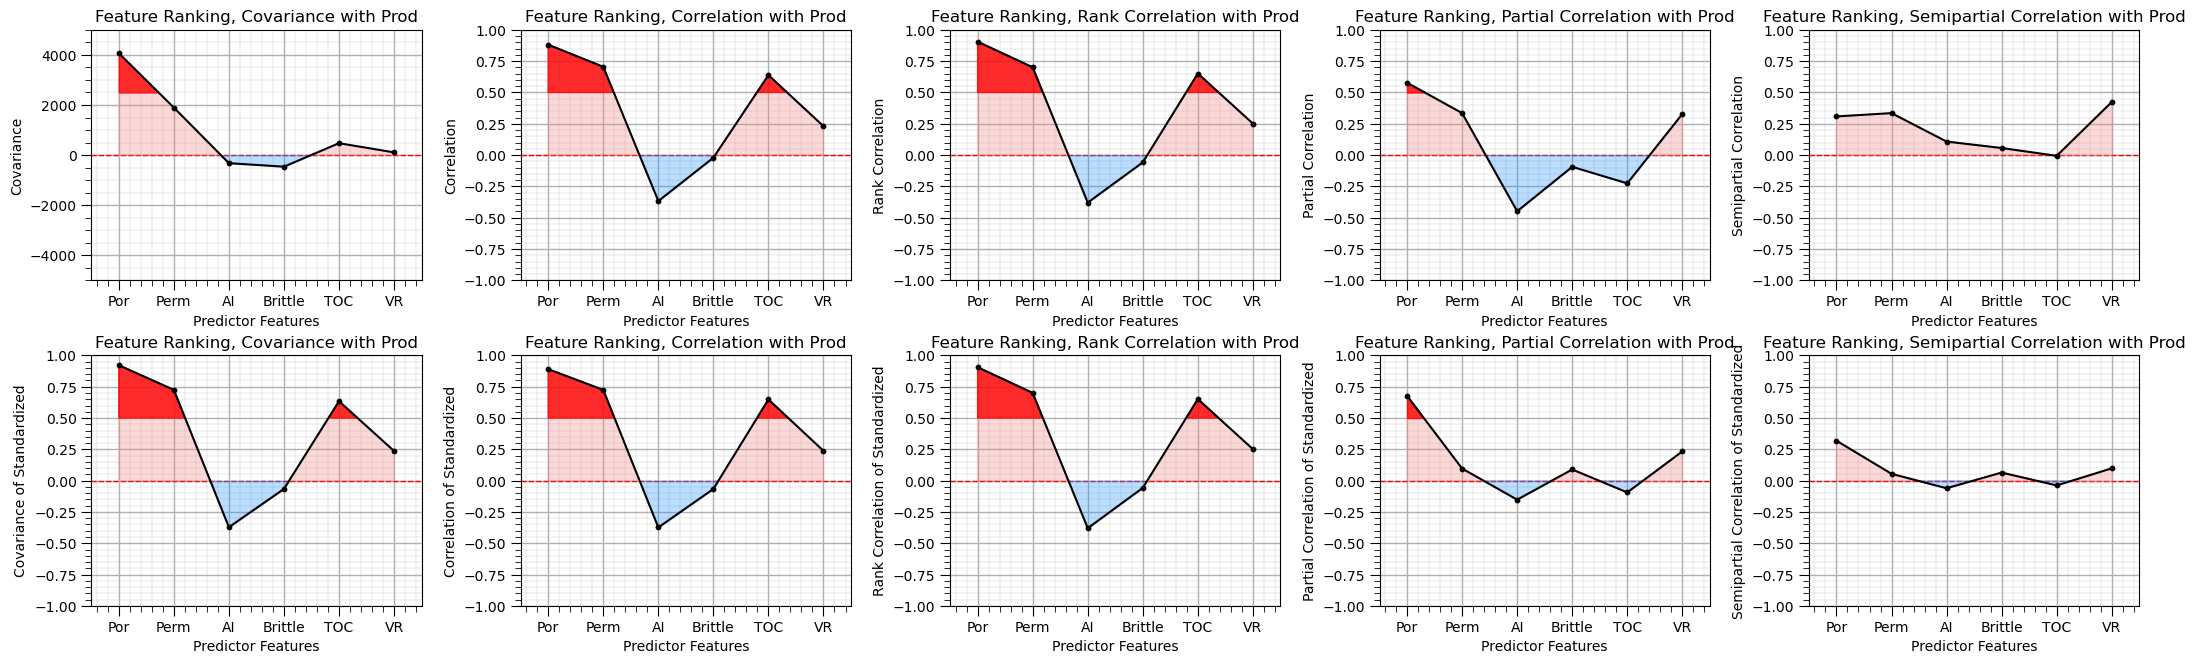

In [61]:
plt.subplot(2,5,1)
feature_rank_plot(pred,covariance,-5000.0,5000.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance',0.5)

plt.subplot(2,5,2)
feature_rank_plot(pred,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation',0.5)

plt.subplot(2,5,3)
feature_rank_plot(pred,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplot(2,5,4)
feature_rank_plot(pred,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

plt.subplot(2,5,5)
feature_rank_plot(pred,semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation',0.5)

plt.subplot(2,5,6)
feature_rank_plot(pred,stand_covariance,-1.0,1.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance of Standardized',0.5)

plt.subplot(2,5,7)
feature_rank_plot(pred,stand_correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation of Standardized',0.5)

plt.subplot(2,5,8)
feature_rank_plot(pred,stand_rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation of Standardized',0.5)

plt.subplot(2,5,9)
feature_rank_plot(pred,stand_partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation of Standardized',0.5)

plt.subplot(2,5,10)
feature_rank_plot(pred,stand_semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation of Standardized',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.3); plt.show()

What can you observe:

* covariance is now equal to correlation coefficient
* the semipartial correlations are sensitive to the feature standardization (affine correlation or normal score transform).

### Conditional Statistics

We will separate the wells into low, mid and high production and access the difference in the conditional statistics.  

* This will provide a more flexible method to compare the relationship between each feature and production

* If the conditional statistics change significantly then that feature is informative

We are going to make a single violin plot over all of our features

* We need a cateogrical feature for production, we truncate production to High or Low

```python
df['tProd'] = np.where(df['Prod']>=4000, 'High', 'Low') 
```

* We will need to standardize all of our features so we can observe their relative differences together

```python
x = df[['Por','Perm','AI','Brittle','TOC','VR']]
x_stand = (x - x.mean()) / (x.std())      
```
* This code extracted the features into a new DataFrame 'x', then applied the standardization operation on each column (feature)

* Then we add the truncated production feature into the standardized features

```python 
x = pd.concat([df['tProd'],x_stand.iloc[:,0:6]],axis=1)
```

* We can then apply the melt command to unpivot the DataFrame

```python
x = pd.melt(x,id_vars="tProd",var_name="Predictors",value_name='Standardized_Value')
```

* We now have a long DataFrame (6 features x 200 samples = 12000 rows) with:

    * production: Low or High
    * features: Por, Perm, AI, Brittle, TOC or VR
    * standardized feature value
    
We can then build our violin plot 

* x is our predictor features
* y is the standardized values for the predictor features (all now in one column)
* hue is the production level High or Low
* split is True so the violins are split in half
* inner is quartiles for P25, P50 and P75 are plotted as dashed lines

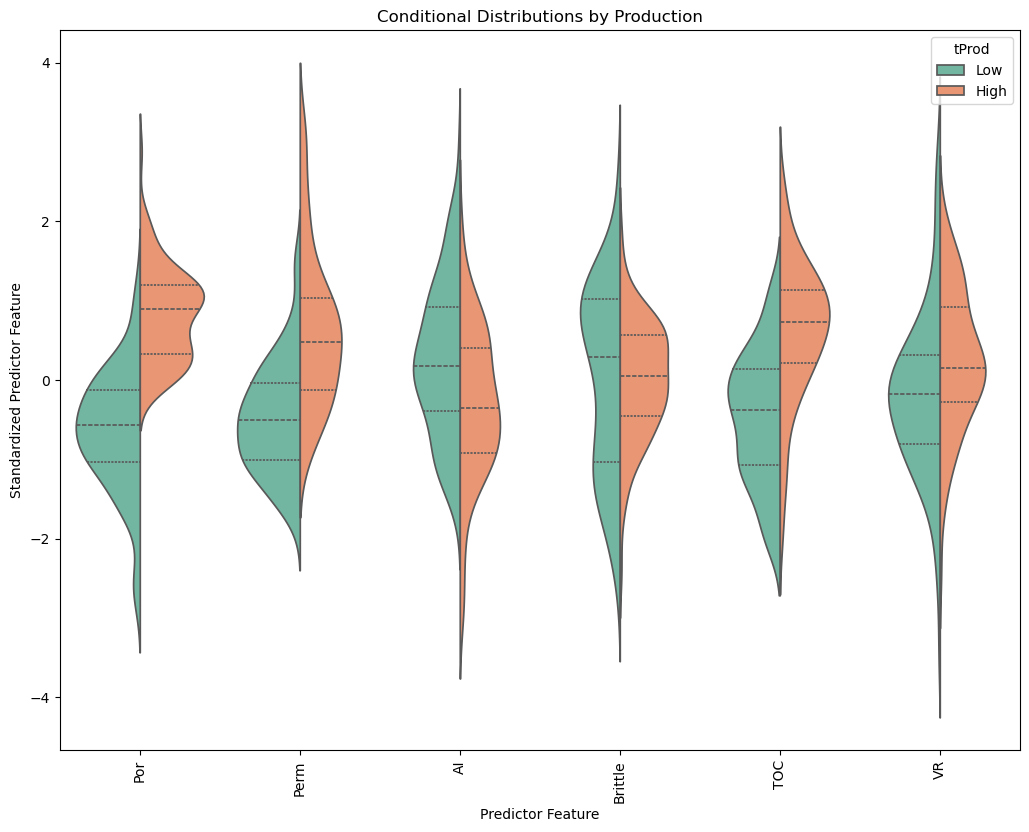

In [63]:
df['tProd'] = np.where(df['Prod']>=4000, 'High', 'Low')       # make a high and low production categorical feature

x_temp = df[pred]
x_temp_stand = (x_temp - x_temp.mean()) / (x_temp.std())      # standardization by feature
x_temp = pd.concat([df['tProd'],x_temp_stand.iloc[:,0:6]],axis=1) # add the production categorical feature to the DataFrame
x_temp = pd.melt(x_temp,id_vars="tProd",var_name="Predictor Feature",value_name='Standardized Predictor Feature') # unpivot the DataFrame

plt.subplot(111)
sns.violinplot(x="Predictor Feature", y="Standardized Predictor Feature", hue="tProd", data=x_temp,split=True, inner="quart", palette="Set2")
plt.xticks(rotation=90); plt.title('Conditional Distributions by Production')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2); plt.show()

From the violin plot we can observe that the conditional distributions of porosity, permeability, TOC have the most variation between low and high production wells.

We can replace the plot with box and whisker plots of the conditional distributions.  

* Box and whisker plots improve our ability to observe the conditional P25, P75 and the upper and lower bounds from the Tukey outlier test.

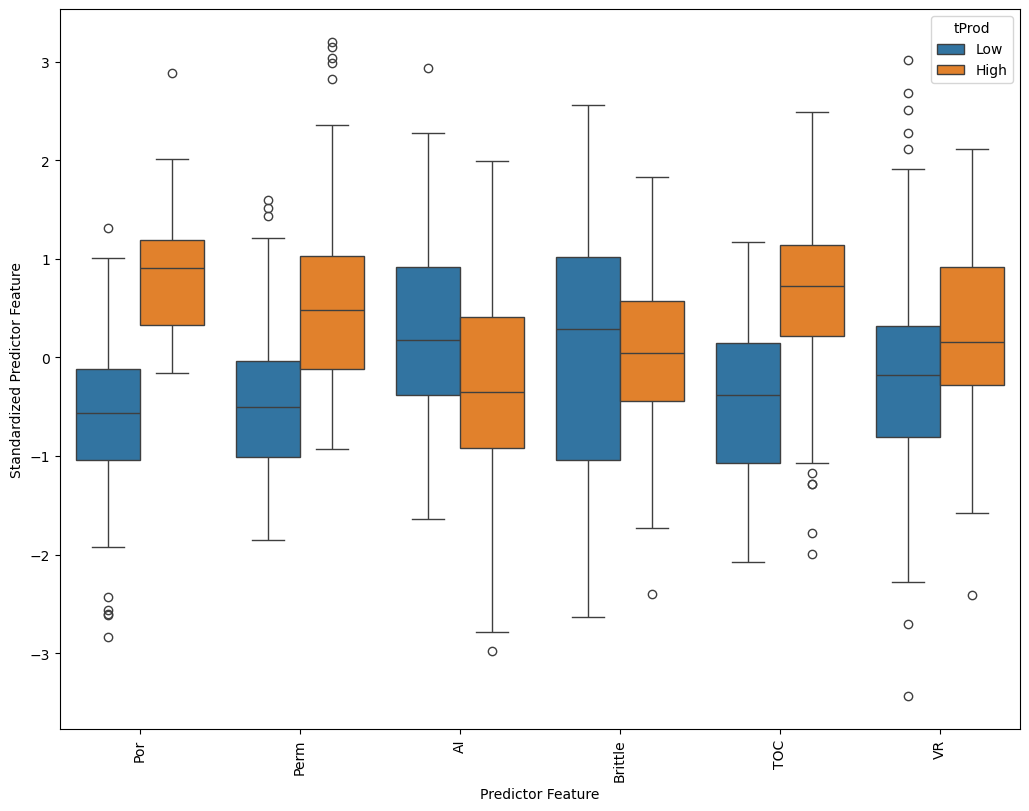

In [65]:
plt.subplot(111)
sns.boxplot(x="Predictor Feature", y="Standardized Predictor Feature", hue="tProd", data=x_temp)
plt.xticks(rotation=90)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

df = df.drop(['tProd'], axis = 1)

From the conditional box plot we can observe that the conditional distributions of porosity, permeability, TOC have the most variation between low and high production wells.

* We can observed the outliers in porosity, permeability (upper tail), total organic carbon (lower tail) and vitrinite reflectance. 

### Variance Inflation Factor (VIF)

A measure of linear multicolinearity between a predictor feature ($X_i$) a nd all other predictor features ($X_j, \forall j \ne i$).

First we calculate a linear regression for a predictor feature given all the other predictor features.

$$
X_i = \sum_{j, j \ne i}^m X_j + \epsilon
$$

From this model we determin the coefficient of determination, $R^2$, known as variance explained.

Then we calculate the Variance Inflation Factor as:

$$
VIF = \frac{1}{1 - R^2}
$$

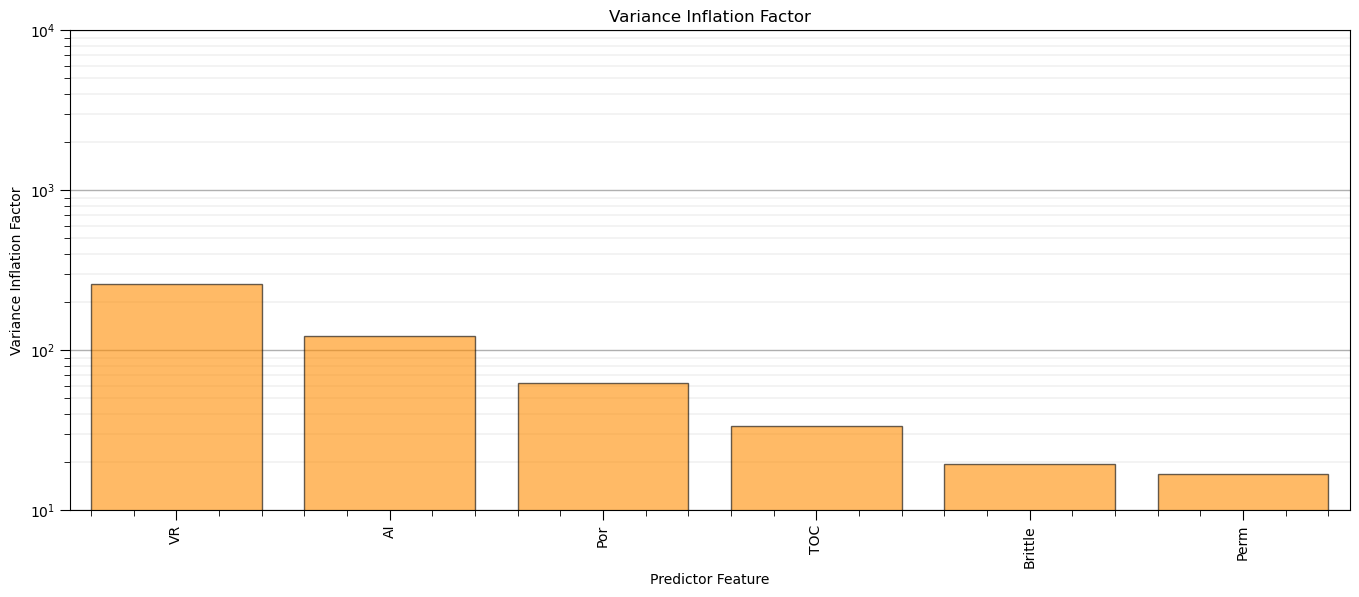

In [67]:
vif_values = []
for i in range(x.shape[1]):
    vif_values.append(variance_inflation_factor(x.values, i))

vif_values = np.asarray(vif_values)
indices = np.argsort(vif_values)[::-1]                  # find indicies for descending order

plt.subplot(111)                                        # plot the feature importance 
plt.title("Variance Inflation Factor")
plt.bar(range(x.shape[1]), vif_values[indices],edgecolor = 'black',
       color="darkorange",alpha=0.6, align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90); 

plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

plt.xlim([-0.5, x.shape[1]-0.5]); plt.yscale('log'); plt.ylim([1.0e1,1.0e4])
plt.xlabel('Predictor Feature'); plt.ylabel('Variance Inflation Factor')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

Vitrinite reflectance has the least linear redundancy while permeability has the most linear redudancy with other predicotr features.

* recall that variance inflation factor does not integrate the relationship between each predictor feature and the response feature.

## Model-based Feature Ranking 

With these methods we evaluate the performance of the features in building an actual predictive model. Let's start with $B$ coefficients.

### Ranking Method - $B$ Coefficients / Beta Weights 

We could also consider $B$ coefficients.  These are the linear regression coefficients without standardization of the variables. Let's use the linear regression method that is available in the SciPy package.

The estimator for $Y$ is simply the linear equation:

\begin{equation}
Y^* = \sum_{i=1}^{m} b_i X_i + c
\end{equation}

The $b_i$ coefficients are solved to minimize the squared error between the estimates, $Y^*$ and the values in the training dataset, $Y$.

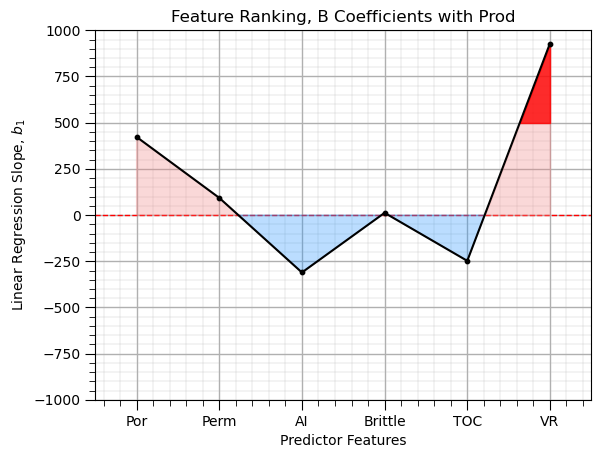

In [69]:
reg = LinearRegression()                                      # instantiate a linear regression model                   
reg.fit(df[pred],df[resp])                                    # train the model
b = reg.coef_

plt.subplot(111)
feature_rank_plot(pred,b,-1000.0,1000.0,0.0,'Feature Ranking, B Coefficients with ' + resp,r'Linear Regression Slope, $b_1$',0.5)

The ouput is the $b$ coefficients, ordered over our features from $b_i, i = 1,\ldots,n$ and then the intercept, $c$, that I have removed to avoid confusion.

* we see the negative contribution of AI and TOC
* the results are very sensitive to the magnitudes of the variances of the predictor features. 

We can remove this sensitivity by working with standardized features.

### Ranking Method - $\beta$ Coefficients / Beta Weights 

$\beta$ coefficients are calculated as the linear regression of the coefficients after we have standardized the predictor and response features to have a variance of one.  

\begin{equation}
\sigma^2_{X^s_i} = 1.0 \quad \forall \quad i = 1,\ldots,m, \quad \sigma^2_{Y^s} = 1.0
\end{equation}

The estimator for $Y^s$ standardized is simply the linear equation:

\begin{equation}
Y^{s*} = \sum_{i=1}^{m} \beta_i X^s_i + c
\end{equation}

It is convenient that we have just standardized all our variables to have a variance of 1.0 just recently (see above). Let's use the same linear regression method again on the standardized features to get $\beta$ coefficients.

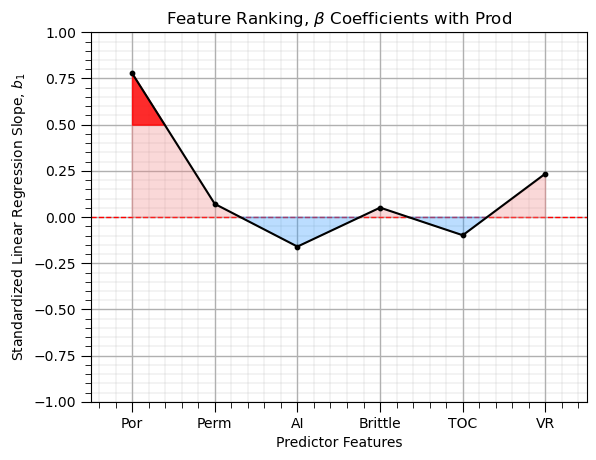

In [71]:
reg = LinearRegression()
reg.fit(dfS[pred],dfS[resp])
beta = reg.coef_

plt.subplot(111)
feature_rank_plot(pred,beta,-1.0,1.0,0.0,r'Feature Ranking, $\beta$ Coefficients with ' + resp,r'Standardized Linear Regression Slope, $b_1$',0.5)

Some observations:

* the change between $b$ and $\beta$ coefficients is not just a constant scaling on the ranking metrics, because the the linear model coefficients are also sensitive to the ranges and magnitudes of the features.

* with beta coefficients porosity, acoustic impedance and total organic carbon have higher rank for estimating production

### Ranking Method - Feature Importance

A variety of machine learning methods provide measures of feature importance, for example decision trees the reduction in mean square error through inclusion of each feature and is summarized as:

$$
FI(x) = \sum_{t \in T_f} \frac{N_t}{N} \Delta_{MSE_t}
$$

where $T_f$ are all nodes with feature $x$ as the split, $N_t$ is the number of training samples reaching node $t$, $N$ is the total number of samples in the dataset and $\Delta_{MSE_t}$ is the reduction in MSE with the $t$ split.

Note, feature importance can be calculated in a similar manner to MSE above for the case of classification trees with **Gini Impurity**. 

Let's look at the feature importance from a random forest regressor fit to our data.

* We instantiate a random forest with default hyperparameters. This results in unlimited complexity, over-trained trees in our forest. The averaging of these trees takes care of the overfit issue.

* Then we train our random forest and extract the importances (expectation over all the trees)

* we can also extract the feature importances over all the trees in the forest and summarize with the standard deviation to access the robustness, uncertainty of our feature importance measure

For more information check out my lecture on [random forest](https://www.youtube.com/watch?v=m5_wk310fho&list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&index=39) predictive machine learning.

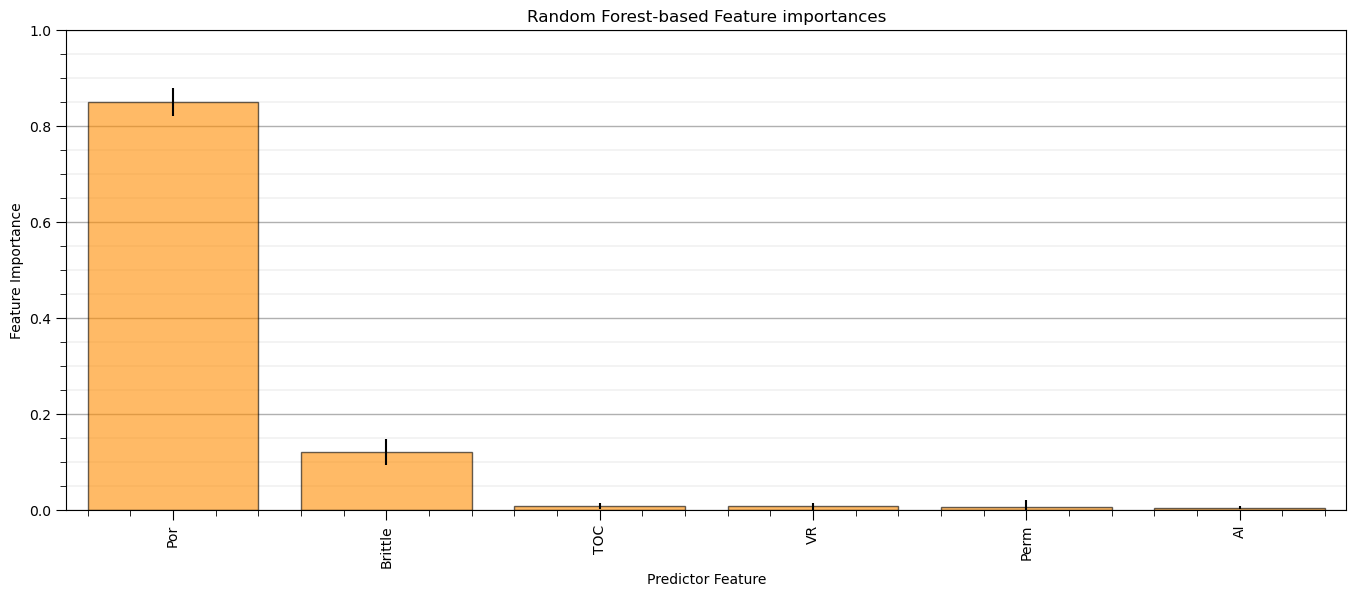

In [73]:
# Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
lab_enc = preprocessing.LabelEncoder(); Y_encoded = lab_enc.fit_transform(Y) # this removes an encoding error 

random_forest = RandomForestRegressor()                 # instantiate the random forest  
random_forest = random_forest.fit(x,np.ravel(Y_encoded)) # fit the random forest
importance_rank = random_forest.feature_importances_    # extract the expected feature importances

importance_rank_stand = importance_rank/np.max(importance_rank)                          # calculate relative mutual information

std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importance_rank)[::-1]             # find indicies for descending order

plt.subplot(111)                                        # plot the feature importance 
plt.title("Random Forest-based Feature importances")
plt.bar(range(x.shape[1]), importance_rank[indices],edgecolor = 'black',
       color="darkorange",alpha = 0.6, yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); 
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.ylim([0.,1.0])
plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

There is more we can do with model-based methods. We will actually test models to assess the incremental impact of each predictor feature! We will try this with recursive feature elimination.

Let's plot the results from the $B$ and $\beta$ coefficients and compare with the previous results.

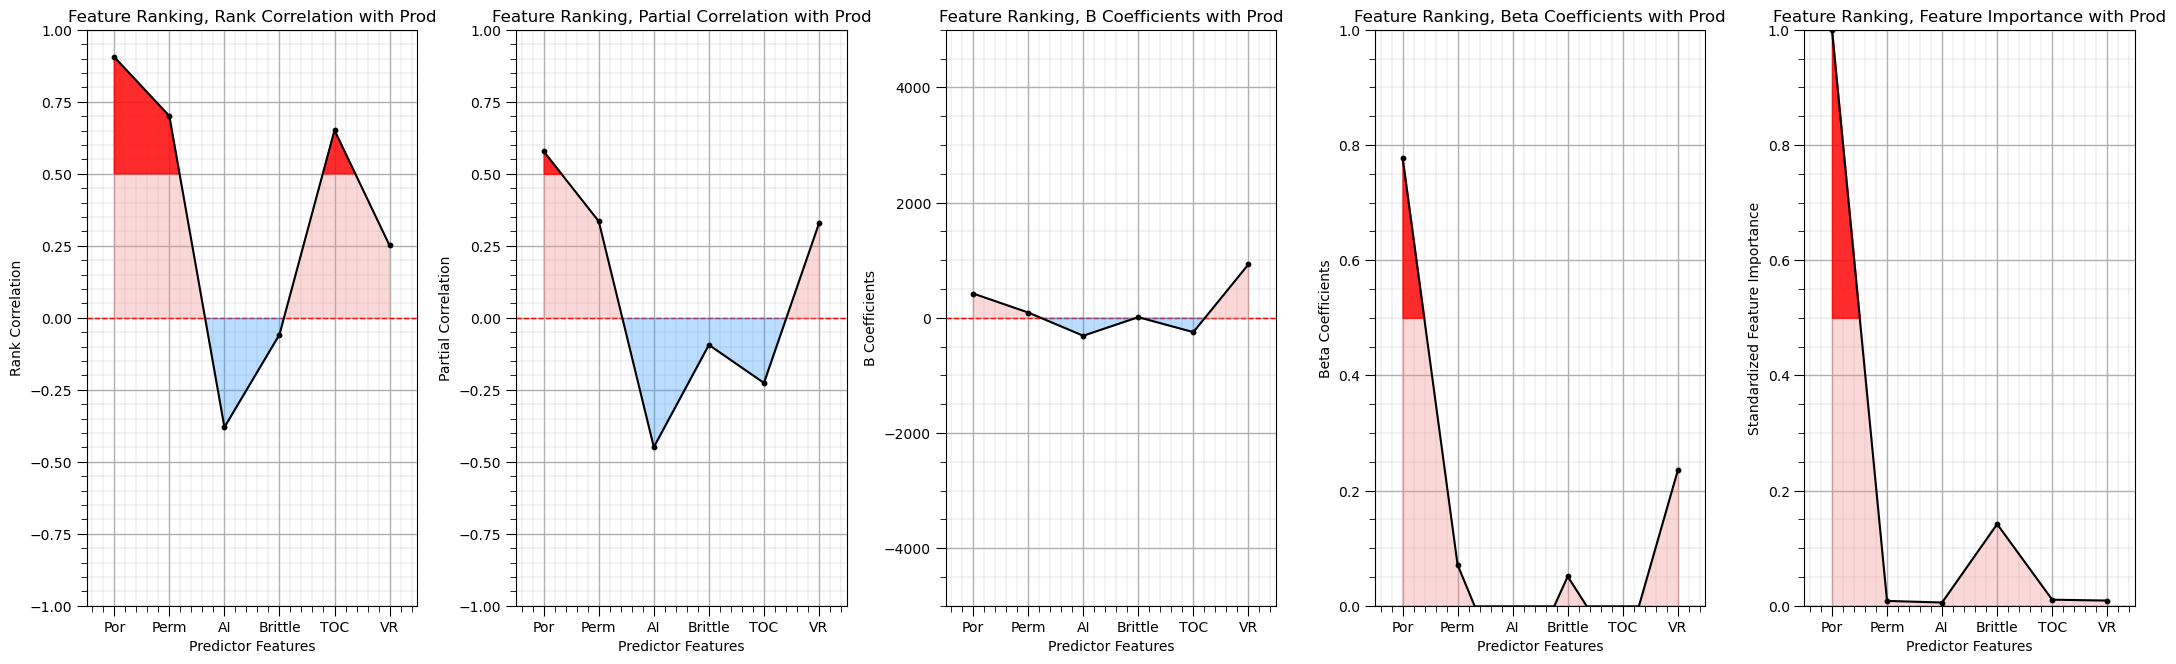

In [75]:
plt.subplot(151)
feature_rank_plot(pred,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplot(152)
feature_rank_plot(pred,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

plt.subplot(153)
feature_rank_plot(pred,b[0:6],-5000.0,5000.0,0.0,'Feature Ranking, B Coefficients with ' + resp,'B Coefficients',0.5)


plt.subplot(154)
feature_rank_plot(pred,beta[0:6],0.0,1.0,0.0,'Feature Ranking, Beta Coefficients with ' + resp,'Beta Coefficients',0.5)

plt.subplot(155)
feature_rank_plot(pred,importance_rank_stand,0.0,1.0,0.0,'Feature Ranking, Feature Importance with ' + resp,'Standardized Feature Importance',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2); plt.show()

### Mutual Information

Mutual information is a generalized approach that quantifies the mutual dependence between two features.  

* quantifies the amount of information gained from observing one feature about the other

* avoids any assumption about the form of the relationship (e.g. no assumption of linear relationship)

* compares the joint probabilities to the product of the marginal probabilities

For discrete or binned continuous features $X$ and $Y$, mutual information is calculated as:

$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X}P_{X,Y}(x,y) log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right)
$$

recall for indepedence:

$$
P_{X,Y}(x,y) = P_X(x) \cdot P_Y(y)
$$

therefore if the two features are independent then the $log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right) = 0$

The joint probability $P_{X,Y}(x,y)$ is a weighting term on the sum and enforces closure.

* parts of the joint distribution with greater density have greater impact on the mutual information metric

For continuous (and nonbinned) features we can applied the integral form.

$$
I(X;Y) = \int_{Y} \int_{X}P_{X,Y}(x,y) log \left( \frac{P_{X,Y}(x,y)}{P_X(x) \cdot P_Y(y)} \right) dx dy
$$

We get a sorted list of the indices in decreasing order of importance with the command

```python
indices = np.argsort(importances)[::-1]
```

the slice reverses the order, for descending order of feature importance.

Feature ranking:
1. feature Por = 1.000000
2. feature Perm = 0.345842
3. feature TOC = 0.270865
4. feature Brittle = 0.073310
5. feature AI = 0.059024
6. feature VR = 0.000000


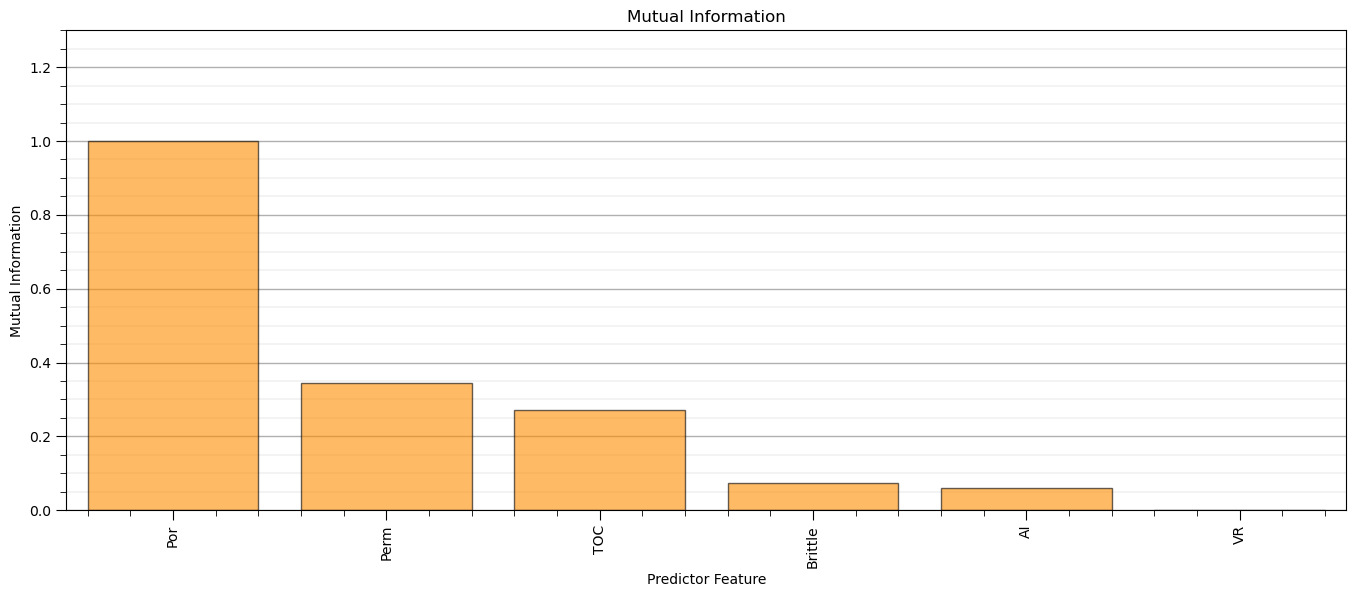

In [77]:
x = df.iloc[:,[1,2,3,4,5,6]]                            # separate DataFrames for predictor and response features
y = df.iloc[:,[7]]

mi = mutual_info_regression(x,np.ravel(y))              # calculate mutual information
mi /= np.max(mi)                                        # calculate relative mutual information

indices = np.argsort(mi)[::-1]                          # find indicies for descending order

print("Feature ranking:")                               # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                                        # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],edgecolor = 'black',
       color="darkorange",alpha=0.6,align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5]); plt.ylim([0,1.3])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlabel('Predictor Feature'); plt.ylabel('Mutual Information')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()


#### Mutual Information Accounting For Relevance and Redundancy

The standard Maximum Relevance - Minumum Redundancy (MRMR) objective function considers a subset of predictor features, i.e., to score predictor feature subsets as metric to identify the most informative subset of predictor features.

* the approach calculates the average mutual information between the subset of predictor features and the response feature minus the average mutual information between the subset of predictor features.

\begin{equation}
MID = \frac{1}{|S|}{\sum_{\alpha \in S} I(X_{\alpha},Y) } - \frac{1}{|S|^2} {\sum_{\alpha \in S}^m \sum_{\beta \in S}^m I(X_{\alpha},X_{\beta})}
\end{equation}

as a measure of $relevance - redundancy$ or 

\begin{equation}
MIQ = \frac{ \frac{1}{|S|}{\sum_{\alpha \in S}^m I(X_{\alpha},Y) } }{ \frac{1}{|S|^2} {\sum_{\alpha \in S}^m \sum_{\beta \in S}^m I(X_{\alpha},X_{\beta})} }
\end{equation}

* as a measure of $\frac{relevance}{redundancy}$.

#### Mutual Information Accounting For Relevance and Redundancy OFAT Variants

I propose that for one-feature-at-a-time (OFAT) predictor feature ranking (predictor feature subset, $S = [X_i]$ and $|S| = 1$) we modify this to the following calculation:

* **relevance** - the mutual information between the selected predictor feature, $X_i$, and the response feature, $Y$
* **redudancy** - the average mutual information between the selected predictor feature, $X_i$, and the remaining predictor features, $X_{\alpha}, \alpha \ne i$.
* we use the quotient form of the calculation from Gulgezen, Cataltepe and Yu (2009).

Our modified version of the Maximum Relevance - Minumum Redundancy (MRMR) objective function for OFAT ranking scores the selected predictor feature $X_i$'s **relavance** as its mutual information with the response feature:

\begin{equation}
I(X_i,Y)
\end{equation}

and **redundancy** between the selected predictor feature, $X_i$, and the remaining predictor features:

\begin{equation}
\frac{1}{|S|-1} \sum_{\alpha=1, \alpha \ne i}^m I(X_i,X_{\alpha})
\end{equation}

were $X$ are predictor features, $Y$ is the response feature, $X_i$ is the specific predictor feature being scored and $|S|$ is the number of predictor features and $I()$ is mutual information between the indicated features. One formulation is a simple difference, relevance minus redudancy,

$$
\Phi_{\Delta}(X_i,Y) = I(X_{\alpha},Y) - \frac{1}{|S|-1} \sum_{\beta=1, \alpha \ne \beta}^m I( X_{\alpha},X_{\beta} ) 
$$

an alternative is a ratio,

$$
\Phi_{r}(X_i,Y) = \frac{ I(X_i,Y) }{ \frac{1}{|S|-1} \sum_{\alpha=1, \alpha \ne i}^m I(X_i,X_{\alpha})}
$$

Here the feature ranks for the mutual information relevance minus redudancy, $\Phi_{\Delta}(X_i,Y)$, approach.

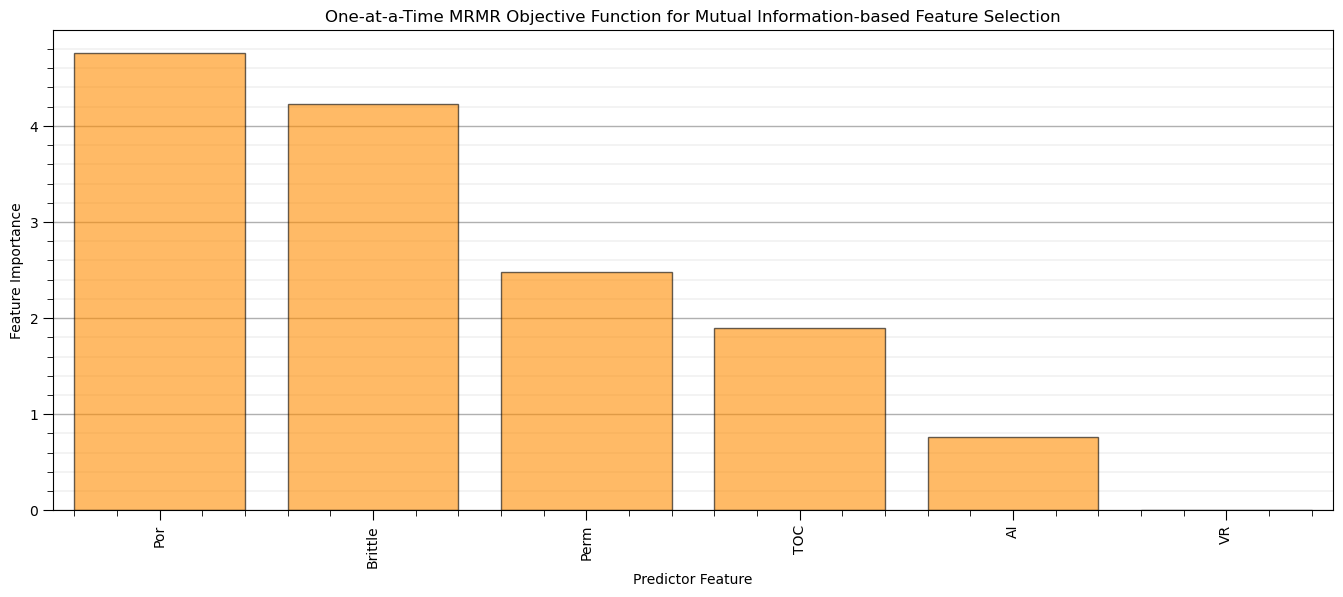

In [79]:
obj_mutual = mutual_information_objective(x,Y)
indices_obj = np.argsort(obj_mutual)[::-1] # find indicies for descending order

plt.subplot(111)                          # plot the relative mutual information 
plt.title("One-at-a-Time MRMR Objective Function for Mutual Information-based Feature Selection")
plt.bar(range(x.shape[1]), obj_mutual[indices_obj],
       color="darkorange",alpha = 0.6, align="center",edgecolor="black")
plt.xticks(range(x.shape[1]), x.columns[indices_obj],rotation=90)
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlim([-0.5, x.shape[1]-0.5]); plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

#### Delta Mutual Information Quotient Accounting for Relevance and Redundancy

We use addapt the mutual information quotient from Gulgezen, Cataltepe and Yu (2009) to develope a OFAT ranking metric.

The standard MRMR objective function that scores the subset of features' **relavance** between the subset of predictor features and the response feature:

\begin{equation}
\frac{1}{|S|}{\sum_{\alpha=1}^m I(X_{\alpha},Y) } 
\end{equation}

and **redundancy** between the the subset of predictor features:

\begin{equation}
\frac{1}{|S|^2} {\sum_{\alpha=1}^m \sum_{\beta=1}^m I(X_{\alpha},X_{\beta})}
\end{equation}

To find the most informative subset of predictor features we must find the subset of features that maximize relevance while minimizing redundacy. We can accomplish this by mazimizing either of these two formulations.

\begin{equation}
MID = \frac{1}{|S|}{\sum_{\alpha=1}^m I(X_{\alpha},Y) } - \frac{1}{|S|^2} {\sum_{\alpha=1}^m \sum_{\beta=1}^m I(X_{\alpha},X_{\beta})}
\end{equation}

or 

\begin{equation}
MIQ = \frac{ \frac{1}{|S|}{\sum_{\alpha=1}^m I(X_{\alpha},Y) } }{ \frac{1}{|S|^2} {\sum_{\alpha=1}^m \sum_{\beta=1}^m I(X_{\alpha},X_{\beta})} }
\end{equation}

I suggest feature ranking through the calculation of the change in $MIQ$ via inclusion and removal of a specific predictor feature ($X_i$).

\begin{equation}
\Delta MIQ_i = \frac{ \frac{1}{|S|}{\sum_{\alpha=1}^m I(X_{\alpha},Y) } }{ \frac{1}{|S|^2} {\sum_{\alpha=1}^m \sum_{\beta=1}^m I(X_{\alpha},X_{\beta})} } - \frac{ \frac{1}{|S|}{\sum_{\alpha=1,\alpha \ne i}^m I(X_{\alpha},Y) } }{ \frac{1}{|S|^2} {\sum_{\alpha=1,\alpha \ne i}^m \sum_{\beta=1,\beta \ne i}^m I(X_{\alpha},X_{\beta})} }
\end{equation}

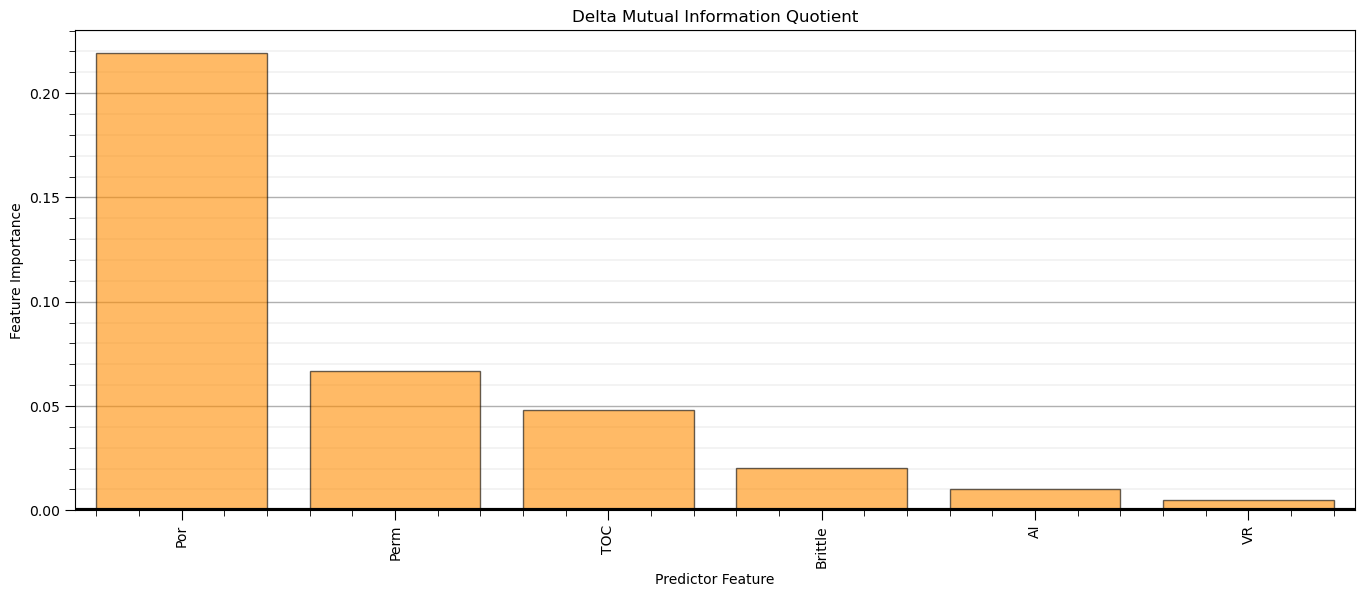

In [81]:
delta_mutual_information = delta_mutual_information_quotient(x,Y)

indices_delta_mutual_information = np.argsort(delta_mutual_information)[::-1] # find indicies for descending order

plt.subplot(111)                                              # plot the relative mutual information 
plt.title("Delta Mutual Information Quotient")
plt.bar(range(x.shape[1]), delta_mutual_information[indices_delta_mutual_information],
       color="darkorange",alpha = 0.6,align="center",edgecolor = 'black')
plt.xticks(range(x.shape[1]), x.columns[indices_delta_mutual_information],rotation=90)
plt.xlim([-0.5, x.shape[1]-0.5])
plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([-0.5,x.shape[1]-0.5],[0,0],color='black',lw=3); plt.xlabel('Predictor Feature'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1., wspace=0.2, hspace=0.5)
plt.show()

#### Compare Delta Mutual Information and Variance Inflation Factor

Both of these methods account for predictor feature redundancy

* VIF assumes linearity and does not account for relevance

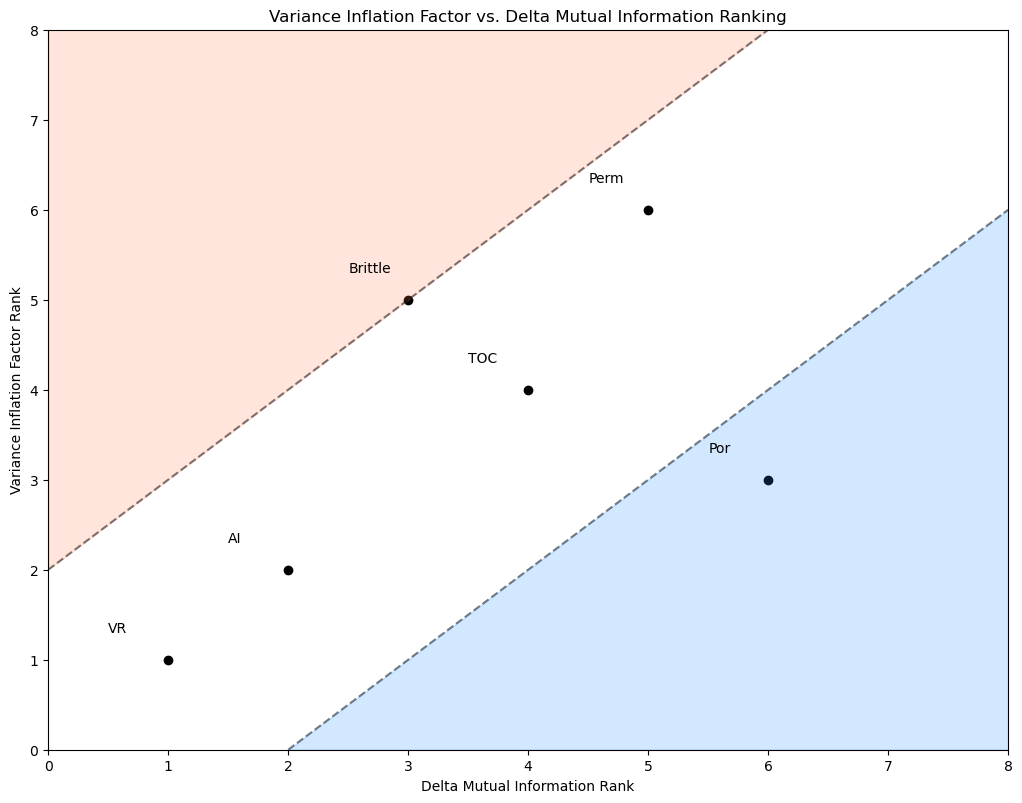

In [83]:
plt.scatter(stats.rankdata(delta_mutual_information),stats.rankdata(-vif_values),c='black',edgecolor='black')
for i, feature in enumerate(x.columns):
    plt.annotate(feature, (stats.rankdata(delta_mutual_information)[i]-0.5,stats.rankdata(-vif_values)[i]+0.3))
plt.xlabel('Delta Mutual Information Rank'); plt.ylabel('Variance Inflation Factor Rank'); plt.title('Variance Inflation Factor vs. Delta Mutual Information Ranking')
plt.xlim(0,len(x.columns)+2); plt.ylim(0,len(x.columns)+2)
plt.plot([2,8],[0,6],color='black',alpha=0.5,ls='--'); 
plt.plot([0,6],[2,8],color='black',alpha=0.5,ls='--')
plt.fill_between([0,6], [2,8], [8,8], color='coral',alpha=0.2,zorder=1)
plt.fill_between([2,8], [0,6], [0,0], color='dodgerblue',alpha=0.2,zorder=1)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2); plt.show()

From mutual information we can observe that porosity, permeability then totoal organic carbon adn brittleness have the greatest departure from general independence.  

#### Summarize All Bivariate Metrics 

We have a wide array of criteria to rank our features.  

* the $B$ coefficient have the same issue as covariance, sensitivity to the univariate variance

* the $\beta$ coefficients remove this sensitivity and are consistent with previous results.

Given all of these methods, I would rank the variables as:

1. Porosity
2. Vitrinite Reflectance
3. Acoustic Impedance
4. Permeability
5. Total Organic Carbon
6. Brittleness

I have assigned these ranks by observing the general trend in these matrics.  Of course, we could make a more quantitative score and rank by weighting each method.

As mentioned before, we should not neglect expert knowledge. If additional information is known about physical processes, causation, and reliability and availability of variables this should be integrated into assigning ranks.

We include a bonus method here, recursive feature elimination, but only provide a simple linear regression model example. More could be done with more complicated models.

### Ranking Method - Recursive Feature Elimination 

Recursive Feature Elimination (RFE) method works by recursively removing features and building a model with the remaining features.

* for the first step, all features are used to build a model and the features are ranked by feature importance or the coeficient

* the least important feature is pruned and the model is rebuilt

* this is repeated until there is only one feature remaining

In this code we make a prediction model based on multilinear regression and indicate that we want to find the best feature based on recursive feature elimination. The algorithm assigns rank $1,\ldots,m$ for all features.

In [85]:
rfe_linear = RFE(LinearRegression(),n_features_to_select=1,verbose=0) # set up RFE linear regression model
df['const'] = np.ones(len(df))                                # let's add one's for the constant term
rfe_linear = rfe_linear.fit(df[pred].values,np.ravel(df[resp])) # recursive elimination
dfS = df.drop('const',axis = 1)                               # remove the ones
print('Recursive Feature Elimination: Multilinear Regression')
for i in range(0,len(pred)):
    print('Rank #' + str(i+1) + ' ' + pred[rfe_linear.ranking_[i]-1])

Recursive Feature Elimination: Multilinear Regression
Rank #1 Brittle
Rank #2 TOC
Rank #3 AI
Rank #4 VR
Rank #5 Por
Rank #6 Perm


The advantages with the recursive elimination method:

* the actual model can be used in assessing feature ranks
* the ranking is based on accuracy of the estimate

but this method is sensitive to:

* choice of model
* training dataset

The feature ranks are quite different from our previous methods.  Many have moved from the previous assessment. Perhaps we should use a more flexible modeling method.

Let's repeat this method with a more flexible machine learning method, decision tree regressor.

In [87]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')            
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
rfe_rf = RFE(RandomForestRegressor(max_depth=3),n_features_to_select=1,verbose=0) # set up RFE linear regression model
df['const'] = np.ones(len(df))                                # let's add one's for the constant term

lab_enc = preprocessing.LabelEncoder(); Y_encoded = lab_enc.fit_transform(Y)

rfe_rf = rfe_rf.fit(x,np.ravel(Y_encoded))                    # recursive elimination
dfS = df.drop('const',axis = 1)                               # remove the ones
print('Recursive Feature Elimination: Random Forest Regression')
for i in range(0,len(pred)):
    print('Rank #' + str(i+1) + ' ' + pred[rfe_rf.ranking_[i]-1])

Recursive Feature Elimination: Random Forest Regression
Rank #1 Por
Rank #2 VR
Rank #3 Brittle
Rank #4 Perm
Rank #5 TOC
Rank #6 AI


Once again, recursive feature elimination for feature ranking is sensitive to the accuracy of the model. 

* the actual prediction model must have its associated hyperparameters tuned and the model accuracy checked.
* for example, in this case the multilinear regression feature ranks are unreliable due to the poor accuracy of the linear model.

## Shapley Values for Feature Ranking

Let's take a random subset of the data, as background values to evaluate our model.

* we subset for faster calculation 

* we should evaluate / enforce efficient coverage of the predictor feature space

Since Shapley values are model based, we must start with building a model

### Build a Random Forest Model

Since Shapley is model based we need to build a model

* Let's start with a good random forest model, observe Shapley and then return here and modify the model

Mean Squared Error on Training =  428100.87 , Variance Explained = 0.82


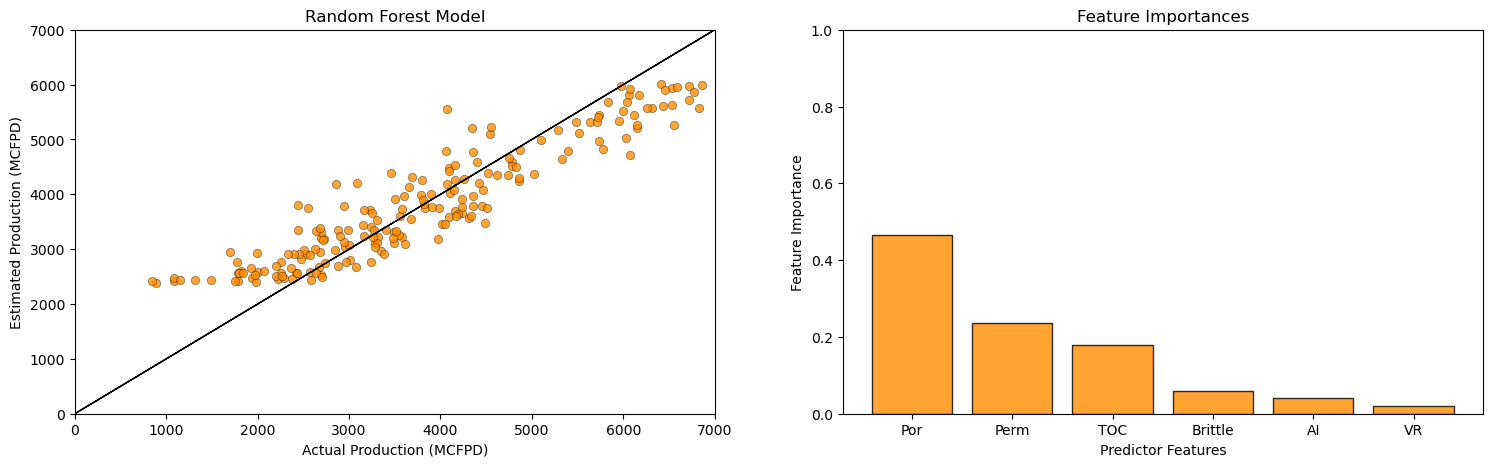

In [89]:
seed = 73093                                                  # set the random forest hyperparameters

# #Underfit random forest
max_leaf_nodes = 2
num_tree = 10
max_features = 2

#Overfit random forest
max_leaf_nodes = 50
num_tree = 1
max_features = 6

# #Good random forest
max_leaf_nodes = 5
num_tree = 300
max_features = 2

rfr = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=seed,n_estimators=num_tree, max_features=max_features)
rfr.fit(X = x, y = Y)

Y_hat = predict_train = rfr.predict(x)

MSE = metrics.mean_squared_error(Y,Y_hat)
Var_Explained = metrics.explained_variance_score(Y,Y_hat)
print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2))

importances = rfr.feature_importances_               # expected (global) importance over the forest fore each predictor feature
std = np.std([rfr.feature_importances_ for tree in rfr.estimators_],axis=0)
indices = np.argsort(importances)[::-1].tolist()

plt.subplot(121)
plt.scatter(Y,Y_hat,s=None, c='darkorange',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Random Forest Model'); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
plt.xlim(0,7000); plt.ylim(0,7000)
plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)

plt.subplot(122)
plt.title("Feature Importances")
plt.bar([pred[i] for i in indices],rfr.feature_importances_[indices],color="darkorange", alpha = 0.8, edgecolor = 'black', yerr=std[indices], align="center")
#plt.xticks(range(X.shape[1]), indices)
plt.ylim(0,1), plt.xlabel('Predictor Features'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

#### Global Shapley Values

Let's review the global Shapley measures.

* sorted bar chart of the arithmetic average of the absolute SHAP value over the background data

* sorted plot of the SHAP value over the background data

* plot of the SHAP value over the background data as a violin plot

Note: all of these methods are applying the global average ($E[X_i]$) for each feature to impute for those cases not including feature $i$.

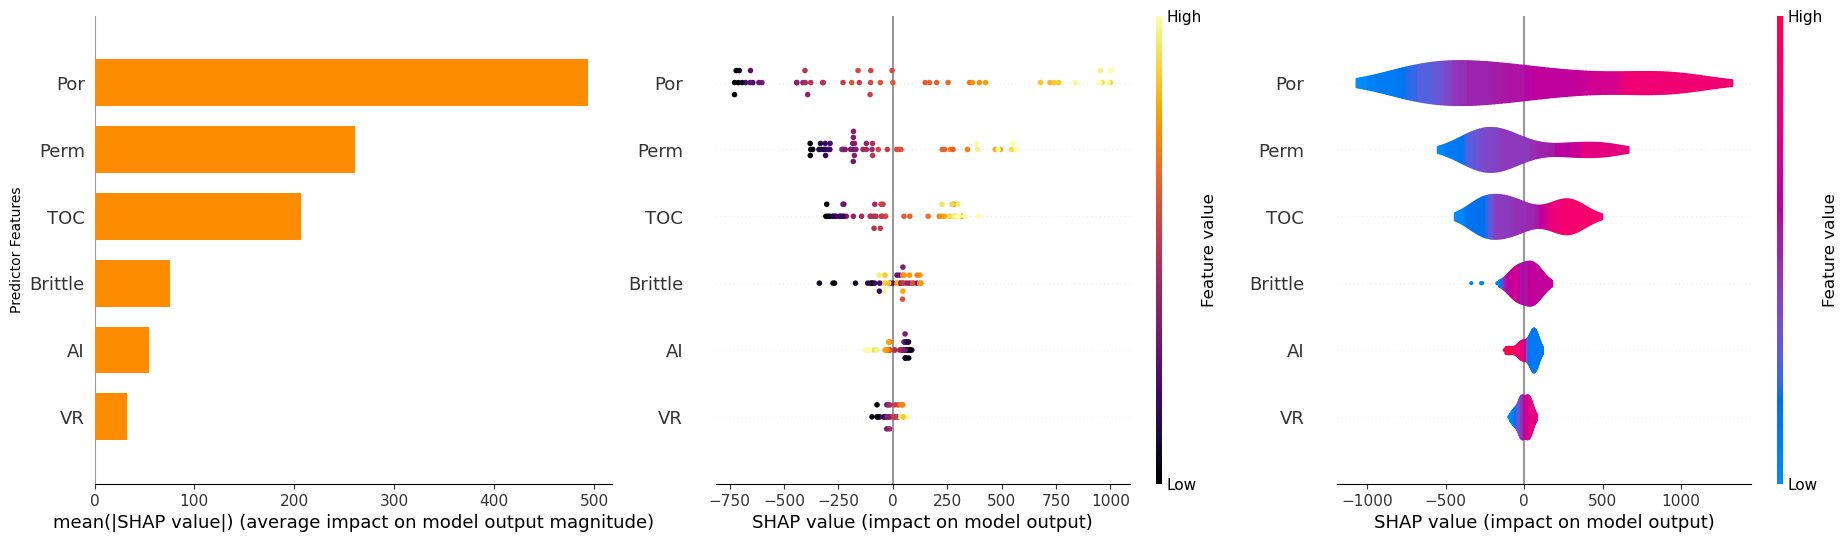

In [91]:
background = shap.sample(x,nsamples=50,random_state=73073) 

shap_values = shap.TreeExplainer(rfr).shap_values(background) # global Shapley Measures

plt.subplot(131)
shap.summary_plot(show=False,feature_names = pred, shap_values = shap_values, features = background, plot_type="bar",color = "darkorange",cmap = plt.cm.inferno)
plt.ylabel('Predictor Features')

plt.subplot(132)
shap.summary_plot(show=False,feature_names = pred, shap_values = shap_values, features = background,cmap = plt.cm.inferno)

plt.subplot(133)
shap.summary_plot(show=False,feature_names = pred, shap_values = shap_values, features = background,plot_type = "violin")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The the center and right plots show the Shapley values for each feature over all the randomly selected background samples, while the plot on the left is the bar chart of the mean absolute Shapley values.

* Porosity, Permeability and TOC are the top features

#### Comments

I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig) | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
